**X-Ray classification**

**Run resent for bodyparts_left = ['XR_FOREARM', 'XR_HAND']**

**Try all parts for 20 epochs - with light data augmentation**

Notes:

* **Metrics exported**


1. Run evaluate to train and not test, Fix pending
2. Didn't delete model after fit, fit afresh new dataset, Fix pending

Given a study containing X-Ray images, build a deep learning model that decides if the study is normal or abnormal. 

You must use at least **2 different architectures**,
* one with your own CNN model (e.g., you can use a model similar to the CNN of the previous project) and 
* one with a popular CNN pre-trained CNN model (e.g., VGG-19, ResNet, etc.). 

Use the MURA dataset to train and evaluate your models. More information about the task and the dataset can be found [here](https://stanfordmlgroup.github.io/competitions/mura/). To download the dataset you must fill out a form, so complete this action as soon as possible.

# Libraries

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import matplotlib.image as mpimg
# from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import random, os
import numpy as np
import pandas as pd
# import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from glob import glob
import gc
# from skimage.transform import resize
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed

from sklearn.metrics import f1_score, recall_score, precision_score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
! pip install -q -U keras-tuner
import keras_tuner as kt

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import lib.data_loader as data_loader
import lib.plot_learning_curves as plot_learning_curves
import models.base_model as base_model
import models.densenet as densenet
import models.resnet as resnet
import json
print("Tensorflow version " + tf.__version__)

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Tensorflow version 2.4.0


In [2]:
# mount data from gdrive and change directory
data_path = 'data/MURA-v1.1/'
directory = 'data/'
! pwd

/tf


# Data  munging

In [3]:
train, test, bodyparts, bodyparts_train_validation_dict, train_generators, valid_generators, test_generators = data_loader.data_loader(data_augmentation='light_augment')


Import train and test data


Create dictionary for training and validation set per body part

Doing a light data augmentation

Create dictionary for training, validation and test set per body part

Found 1139 validated image filenames.
Found 133 validated image filenames.
Found 288 validated image filenames.
Found 4405 validated image filenames.
Found 526 validated image filenames.
Found 465 validated image filenames.
Found 4583 validated image filenames.
Found 523 validated image filenames.
Found 461 validated image filenames.
Found 1649 validated image filenames.
Found 176 validated image filenames.
Found 301 validated image filenames.
Found 7574 validated image filenames.
Found 805 validated image filenames.
Found 563 validated image filenames.
Found 8787 validated image filenames.
Found 965 validated image filenames.
Found 659 validated image filenames.
Found 4992 validated image filenames.
Found 551 validated image filenames.
Found 460 validated image filenames.
Data munging comp

# CNN  with data augmentation

In [20]:
def build_model(input_shape,
                conv_layers,
                conv_activation,
                conv_dropout,
                units,
                output_activation,
                optimizer,
                loss,
                metrics,
                verbose=1):
    
    np.random.seed(1234) # Define the seed for numpy to have reproducible experiments.
    set_seed(9876) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=8*(2**(i+1)),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=0.2,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Add a dense before output layer and drop out
    x = tf.keras.layers.Dense(units=100,
                              activation='relu',
                              name='Dense-1')(x)

    x = tf.keras.layers.Dropout(rate= 0.2, 
                                name='Dropout-{0:d}'.format(conv_layers + 1))(x)
    # Define the output layer.
    output = Dense(
        units=units,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, 
                  outputs=output)
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    # print summary and architecture
    model.summary()

    return model

## Build

## Train

In [21]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=4,
                                             verbose=1)    
def train_model(model, bodypart):
    
    validation_steps = math.ceil(valid_generators[bodypart].n/ valid_generators[bodypart].batch_size)
    print("Using validation_steps = %d" % validation_steps)
    steps_per_epoch = math.ceil(train_generators[bodypart].n / (8*train_generators[bodypart].batch_size))
    print("Using steps_per_epoch = %d" % steps_per_epoch)

    history = model.fit(train_generators[bodypart],
                        validation_data = valid_generators[bodypart],
                        validation_steps = validation_steps,
                        steps_per_epoch = steps_per_epoch,
                        epochs=20,
                        verbose=1,
                        callbacks=[callbacks]
    )
    return history

In [4]:
def eval_func(y_true, y_prob):
    """
    A function calculating the different evaluation metrics on the test set.
    Converts prediction probabilities y_prob to predicted labels y_pred
    """
    y_pred = np.array([1 if prob >= 0.5 else 0 for prob in y_prob])
    y_true = np.array(y_true)

    print(f"Test accuracy: {round(accuracy_score(y_true, y_pred)*100, 2)} %")
    print(f"Test F1 score: {round(f1_score(y_true, y_pred)*100, 2)} %")
    print(f"Test Precision score: {round(precision_score(y_true, y_pred)*100, 2)} %")
    print(f"Test Recall score: {round(recall_score(y_true, y_pred)*100, 2)} %")

In [5]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [8]:
histories_cnn = {}
for bodypart in set(train.bodypart):
    print('-----------')
    print(bodypart)
    model = build_model(input_shape = (320,320,3),
                        conv_layers = 4,
                        conv_activation = 'relu',
                        conv_dropout = 0.2,
                        units = 1,
                        output_activation = 'sigmoid',
                        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                        loss = 'binary_crossentropy',
                        metrics = ['binary_accuracy'])
    histories_cnn[bodypart] = train_model(model, 
                              bodypart)
    print('\nSave training history\n')
    import json
    with open("data/history/model_cnn_20epochs_light_augment_"+bodypart+".json", "w") as file:
        json.dump(histories_cnn[bodypart].history, file)
        print('\nSave model\n')
    print('\nSave model\n')
    model.save("data/models/model_cnn_20epochs_light_augment_"+bodypart)
    model.save("data/models/model_cnn_20epochs_light_augment_"+bodypart+".h5")
    print('\nEvaluate model\n')
    eval_func(test[test['bodypart'] == bodypart]['class'], 
                    model.predict(test_generators[bodypart]))
    print('evaluate_test_generators')
    model.evaluate(test_generators[bodypart], verbose=1)
    print('evaluate_train_generators')
    model.evaluate(train_generators[bodypart], verbose=1)
    print('evaluate_valid_generators')
    model.evaluate(valid_generators[bodypart], verbose=1)
    print("Delete model")
    clean_up(model)

-----------
XR_SHOULDER
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 160, 160, 16)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 160, 160, 16)      0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 160, 160, 32)      4640      
_________________________________________________________________
MaxPool2D-2 (MaxPooling2D)   (None, 80, 80, 32)        0         
_________________________________________________________________
Dropout-2 (Dropout)          (None, 8

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 9s 600ms/step - loss: 0.7999 - binary_accuracy: 0.5054
evaluate_train_generators
139/139 [==============================] - 369s 3s/step - loss: 0.7029 - binary_accuracy: 0.6018
evaluate_valid_generators
16/16 [==============================] - 12s 714ms/step - loss: 0.7834 - binary_accuracy: 0.5162
Delete model
-----------
XR_HUMERUS
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 160, 160, 16)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 160, 160, 16)      0         
_____________

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 7s 633ms/step - loss: 0.7042 - binary_accuracy: 0.4983
evaluate_train_generators
52/52 [==============================] - 146s 3s/step - loss: 0.6541 - binary_accuracy: 0.6345
evaluate_valid_generators
6/6 [==============================] - 4s 629ms/step - loss: 0.6506 - binary_accuracy: 0.6667
Delete model
-----------
XR_HAND
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 160, 160, 16)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 160, 160, 16)      0         
_____________________

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 9s 539ms/step - loss: 0.6743 - binary_accuracy: 0.5891
evaluate_train_generators
156/156 [==============================] - 473s 3s/step - loss: 0.5839 - binary_accuracy: 0.7305
evaluate_valid_generators
18/18 [==============================] - 12s 658ms/step - loss: 0.5671 - binary_accuracy: 0.7482
Delete model


In [9]:
from importlib import reload
reload(plot_learning_curves)

<module 'lib.plot_learning_curves' from '/tf/lib/plot_learning_curves.py'>

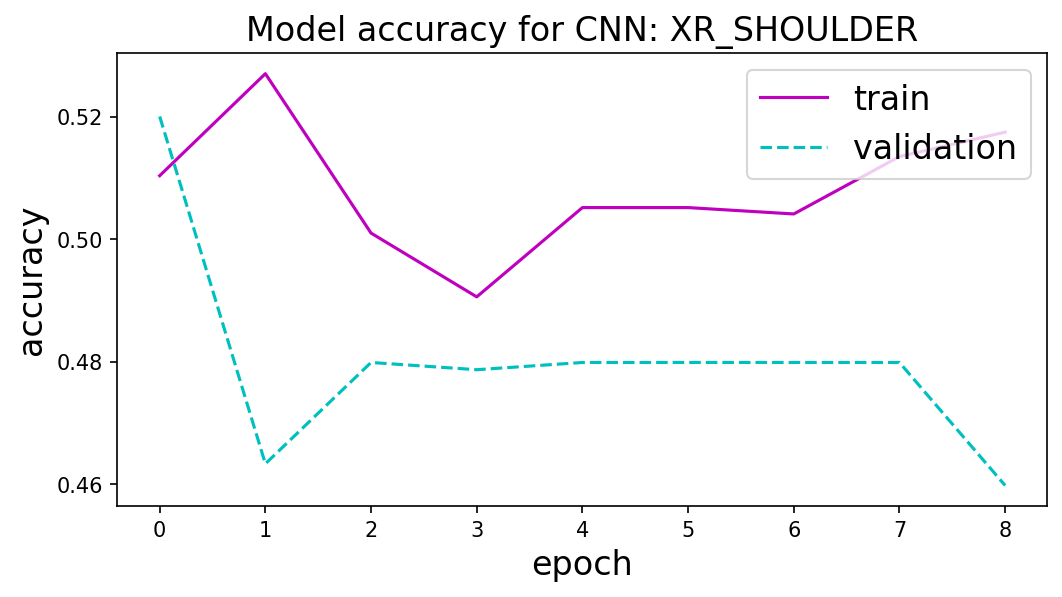

<Figure size 432x288 with 0 Axes>

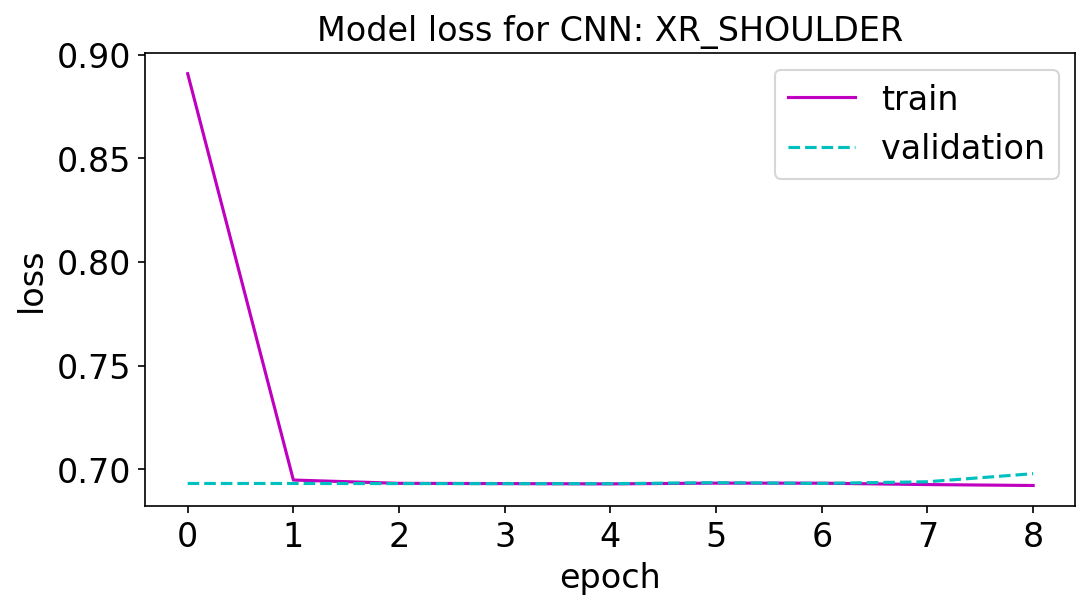

<Figure size 432x288 with 0 Axes>

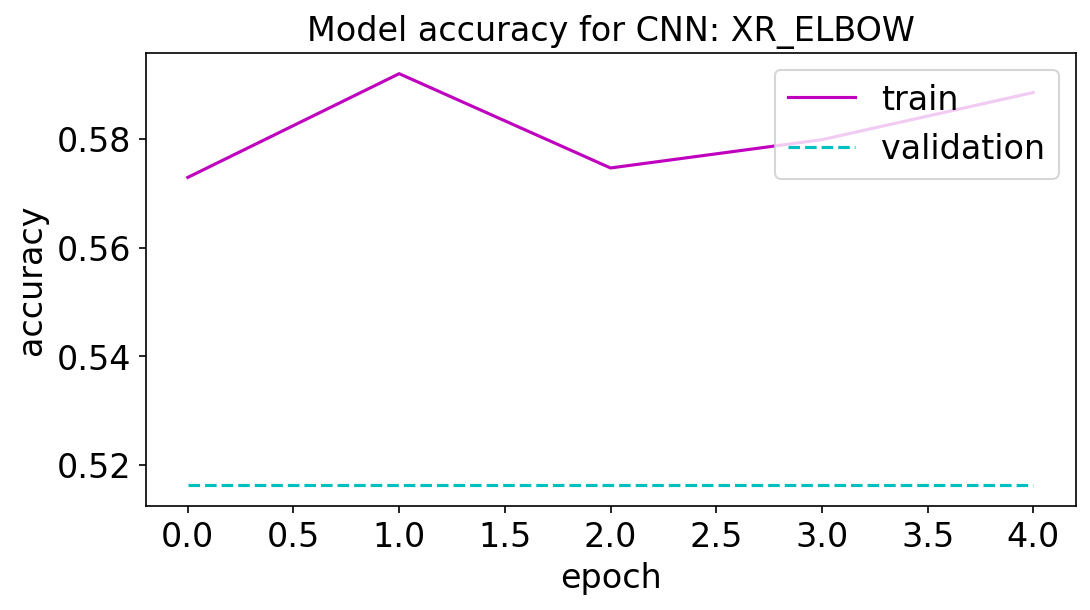

<Figure size 432x288 with 0 Axes>

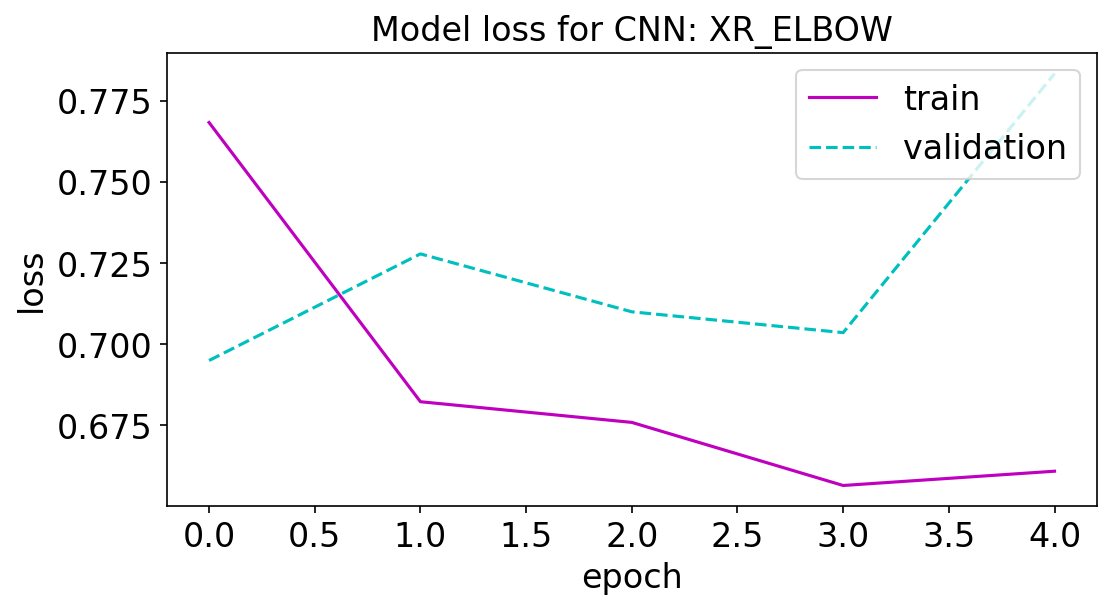

<Figure size 432x288 with 0 Axes>

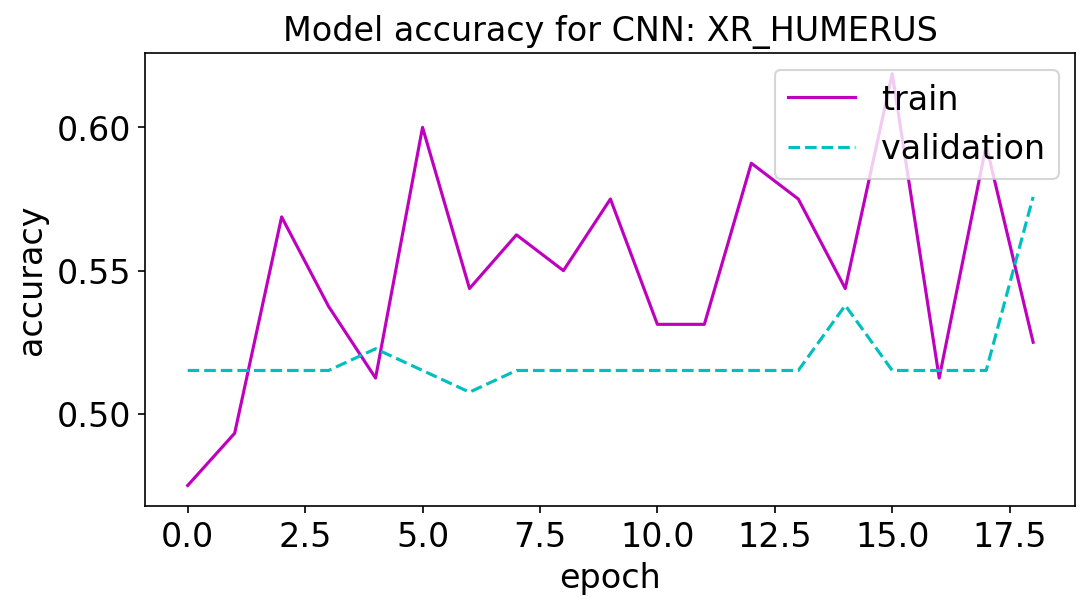

<Figure size 432x288 with 0 Axes>

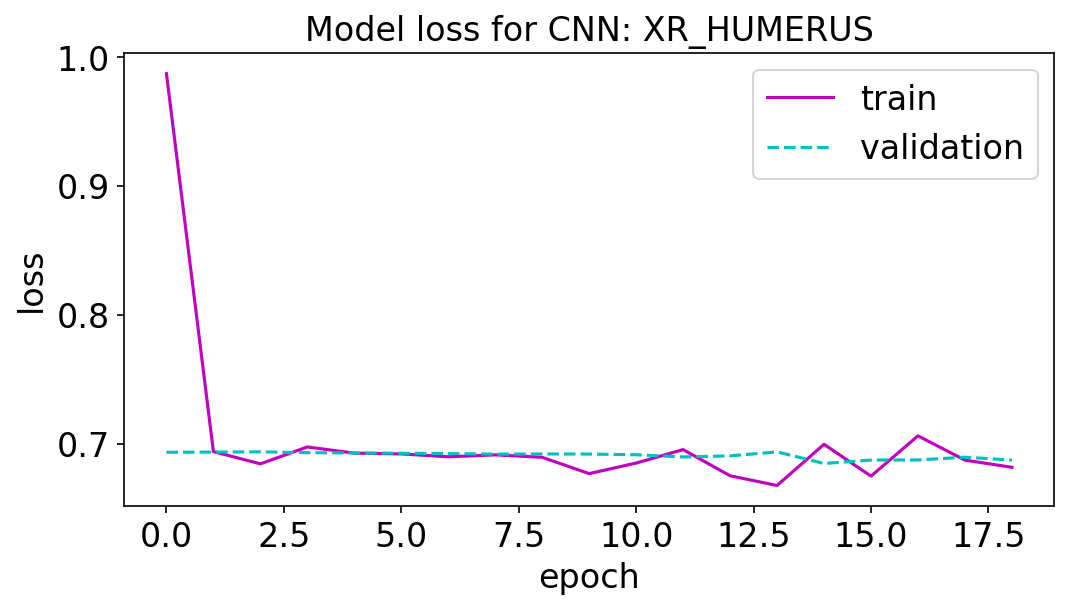

<Figure size 432x288 with 0 Axes>

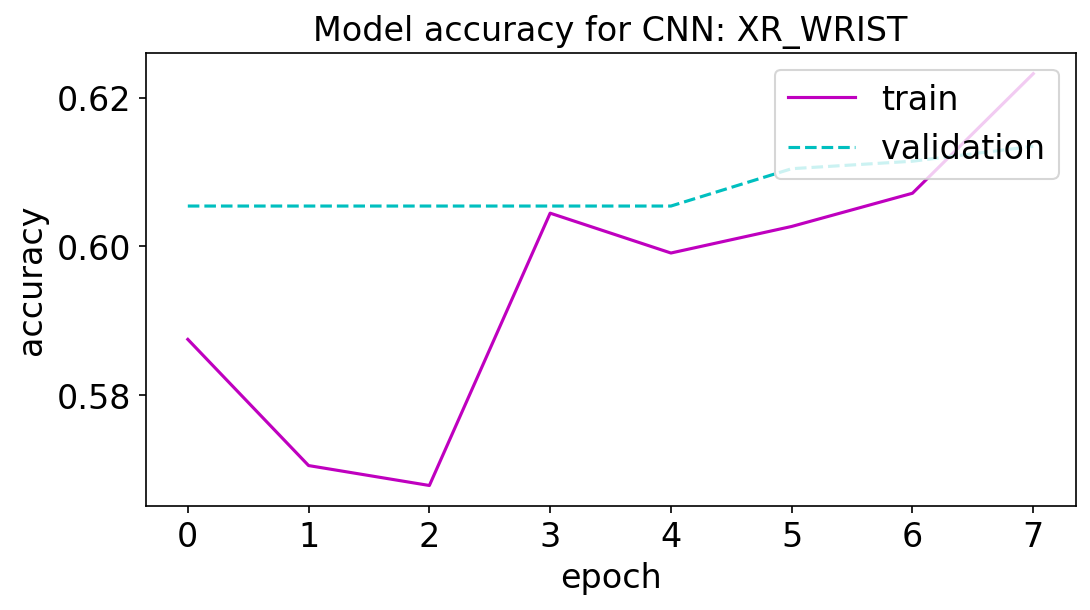

<Figure size 432x288 with 0 Axes>

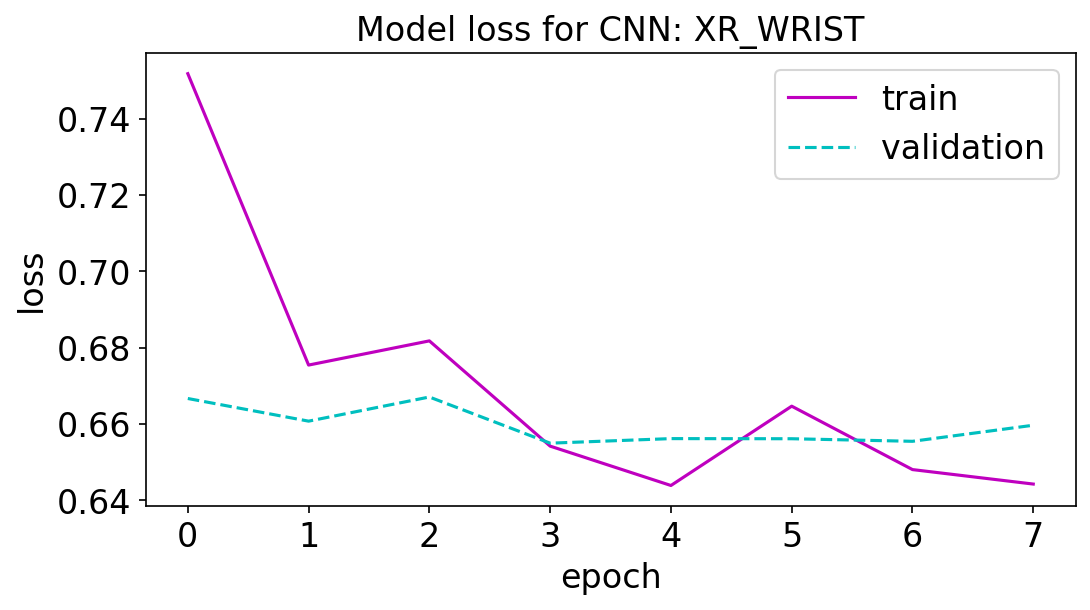

<Figure size 432x288 with 0 Axes>

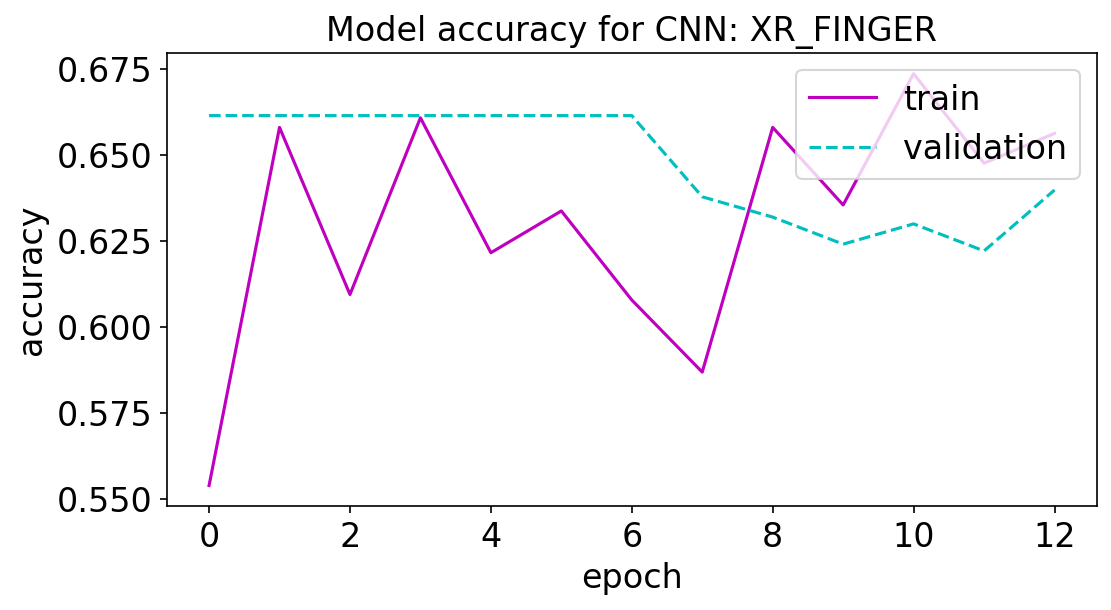

<Figure size 432x288 with 0 Axes>

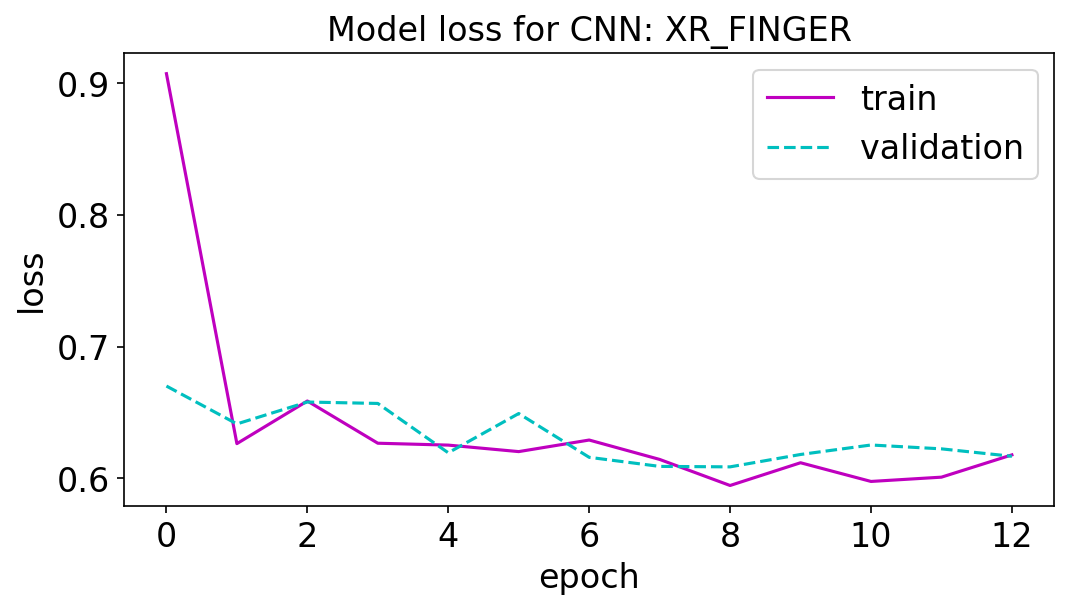

<Figure size 432x288 with 0 Axes>

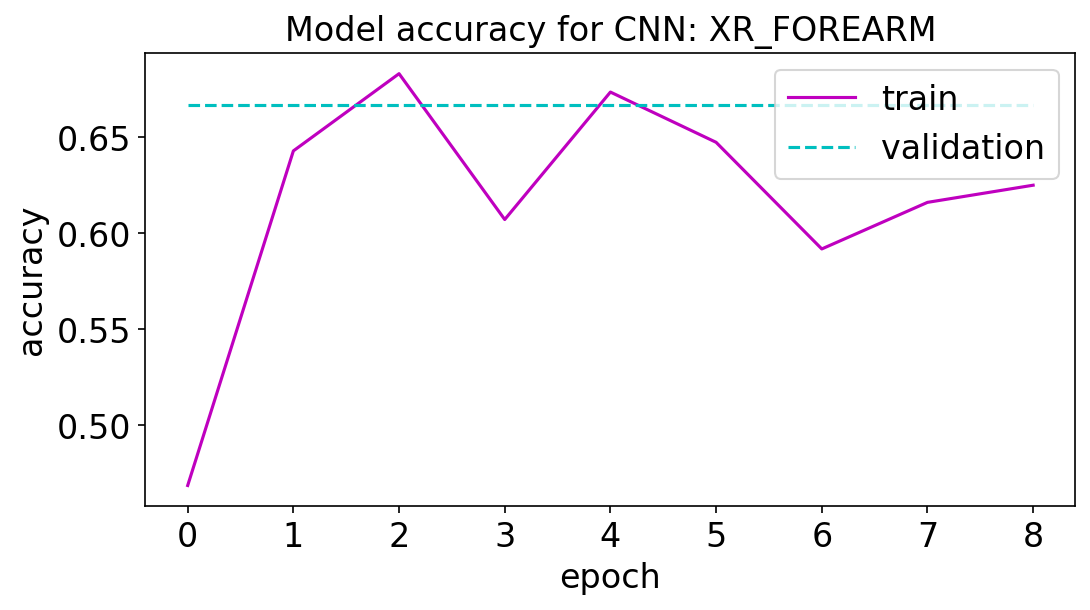

<Figure size 432x288 with 0 Axes>

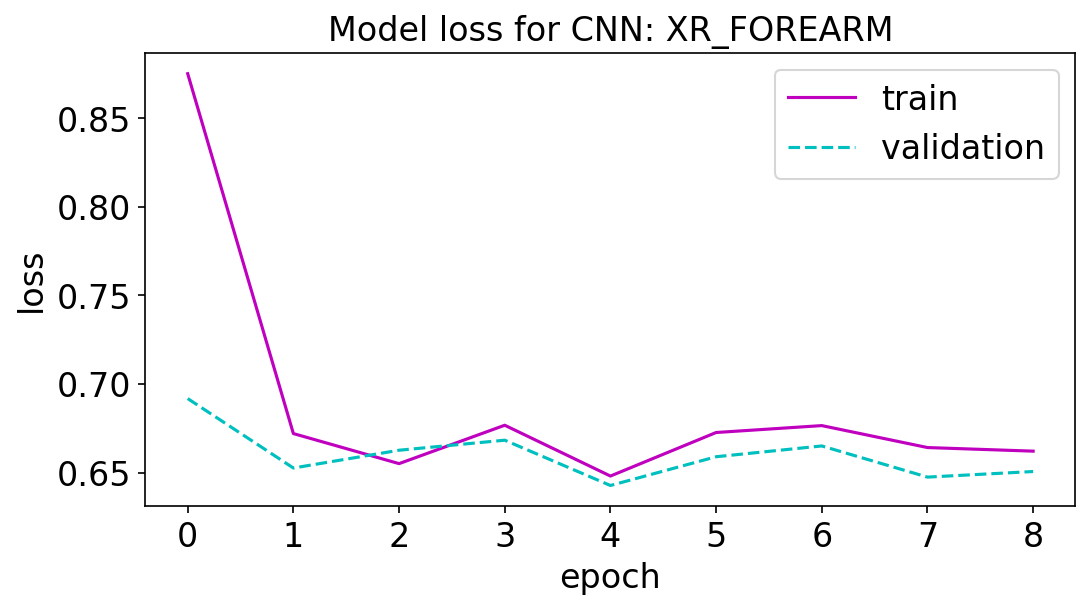

<Figure size 432x288 with 0 Axes>

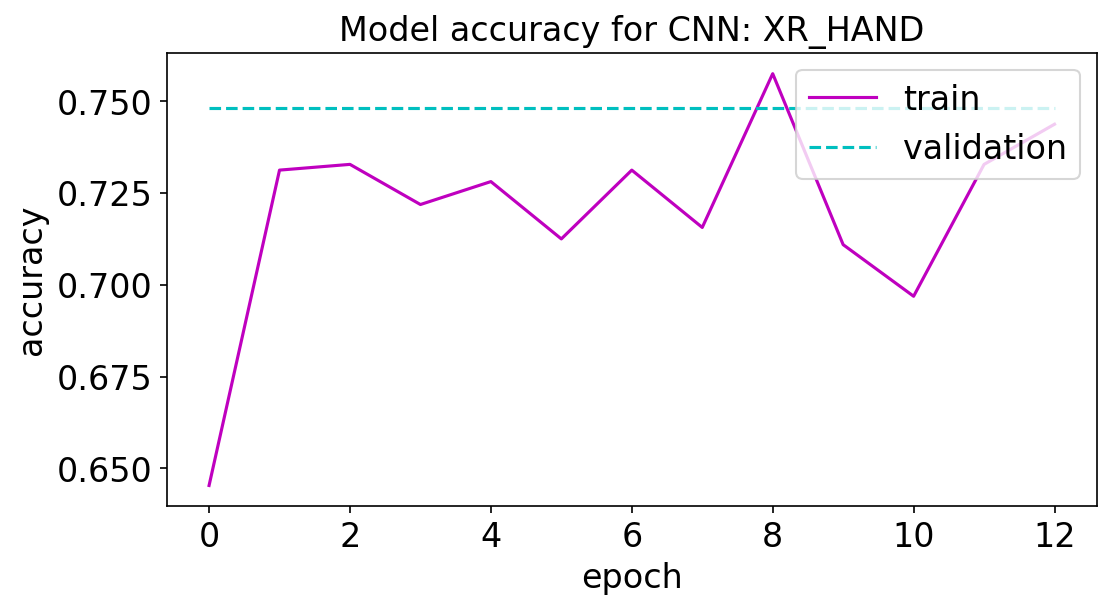

<Figure size 432x288 with 0 Axes>

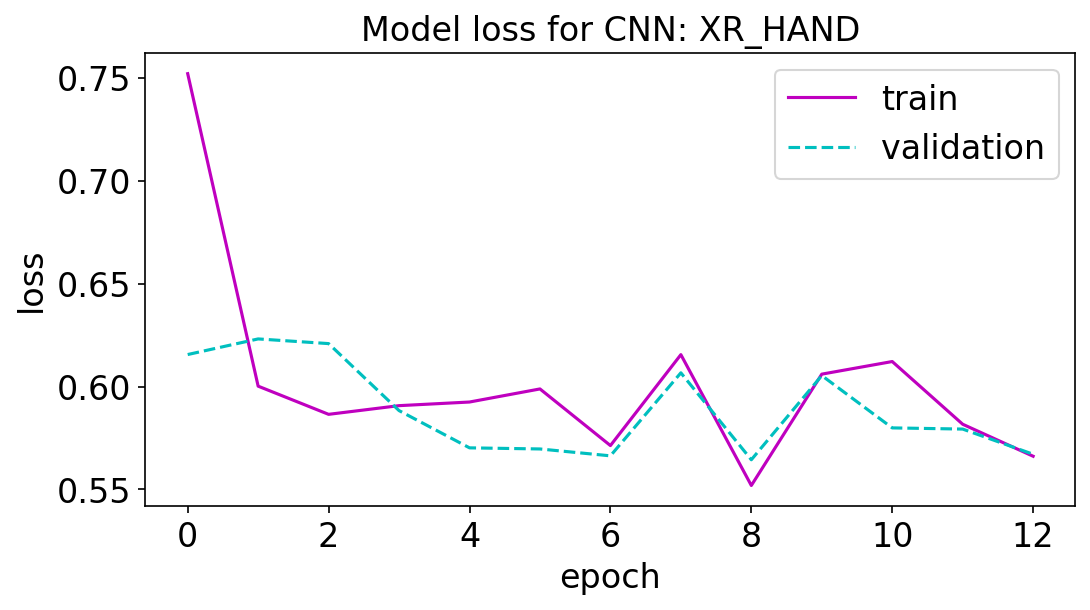

<Figure size 432x288 with 0 Axes>

In [10]:
import json
for bodypart in bodyparts:
    plot_learning_curves.plot_history(histories_cnn[bodypart], 
                                     bodypart,
                                     'base_model_',
                                     20,
                                     data_augmentation='light_augment')

# CNN with pre-trained model

## DenseNet

### Build

In [34]:
# add model on top
def build_model_on_densenet():
  # DenseNet model
  densenet_model = tf.keras.applications.DenseNet121(weights='imagenet',
                                                    input_shape = (320,320,3),
                                                    include_top = False)
  densenet_model.trainable = False
  # add new model on top
  inputs = tf.keras.Input(shape=(320,320,3))
  x = densenet_model(inputs, 
                    training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs, outputs)
  model.summary()

  # train the top layer
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss = 'binary_crossentropy',
                metrics = ['binary_accuracy'])
  return model

In [35]:
densenet_model_top = build_model_on_densenet()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


### Train

In [39]:
callbacks_2 = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                             patience=8,
                                             restore_best_weights=True)

def train_model(model, bodypart):
    validation_steps = math.ceil(valid_generators[bodypart].n/ valid_generators[bodypart].batch_size)
    print("Using validation_steps = %d" % validation_steps)
    steps_per_epoch = math.ceil(train_generators[bodypart].n / (train_generators[bodypart].batch_size))
    print("Using steps_per_epoch = %d" % steps_per_epoch)

    history = model.fit(train_generators[bodypart],
                        validation_data = valid_generators[bodypart],
                        validation_steps = validation_steps,
                        steps_per_epoch = steps_per_epoch,
                        epochs=25,
                        verbose=1,
                        callbacks=[callbacks_2]
    )
    return history

In [40]:
densenet_model_top_histories = {}
for bodypart in set(train.bodypart):
    print('-----------')
    print(bodypart)
    model = build_model_on_densenet()
    densenet_model_top_histories[bodypart] = train_model(densenet_model_top, 
                                              bodypart)
    print('\nSave training history\n')
    with open("data/history/densenet_25epochs_light_augment_"+bodypart+".json", "w") as file:
        json.dump(densenet_model_top_histories[bodypart].history, file)
        print('\nSave model\n')
    print('\nSave model\n')
    model.save("data/models/densenet_25epochs_light_augment_"+bodypart)
    model.save("data/models/densenet_25epochs_light_augment_"+bodypart+".h5")
    print('\nEvaluate model\n')
    eval_func(test[test['bodypart'] == bodypart]['class'], 
                    model.predict(test_generators[bodypart]))
    print('evaluate_test_generators')
    model.evaluate(test_generators[bodypart], verbose=1)
    print('evaluate_train_generators')
    model.evaluate(train_generators[bodypart], verbose=1)
    print('evaluate_valid_generators')
    model.evaluate(valid_generators[bodypart], verbose=1)
    print("Delete model")
    clean_up(model)

-----------
XR_WRIST
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 320, 320, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________
Using validation_steps = 31
Using steps_per_epoch = 275
Epoch 1/25
275/275 [==============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# import json
# densenet_model_top_histories_reloaded = {}
# for bodypart in bodyparts:
#     url = "data/history/densenet_25epochs_light_augment_"+bodypart+".json"
#     f = open(url)
#     densenet_model_top_histories_reloaded[bodypart] = json.load(f)

In [ ]:
# for bodypart in bodyparts:
#     plot_learning_curves.plot_history_from_dict(densenet_model_top_histories_reloaded[bodypart], 
#                                      bodypart,
#                                      'densenet',
#                                      25,
#                                      data_augmentation='light_augment')

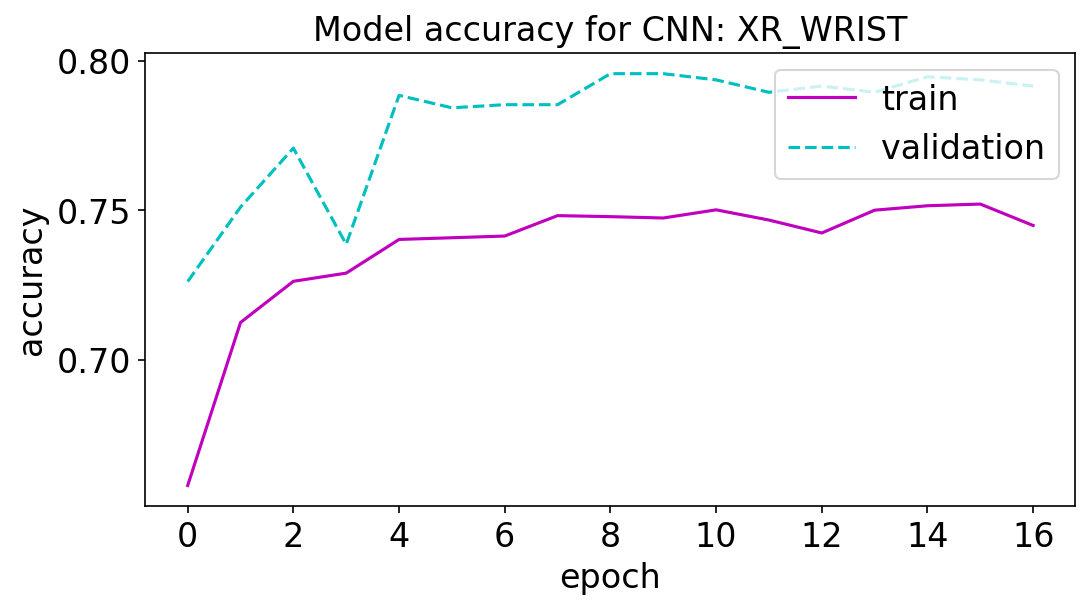

<Figure size 432x288 with 0 Axes>

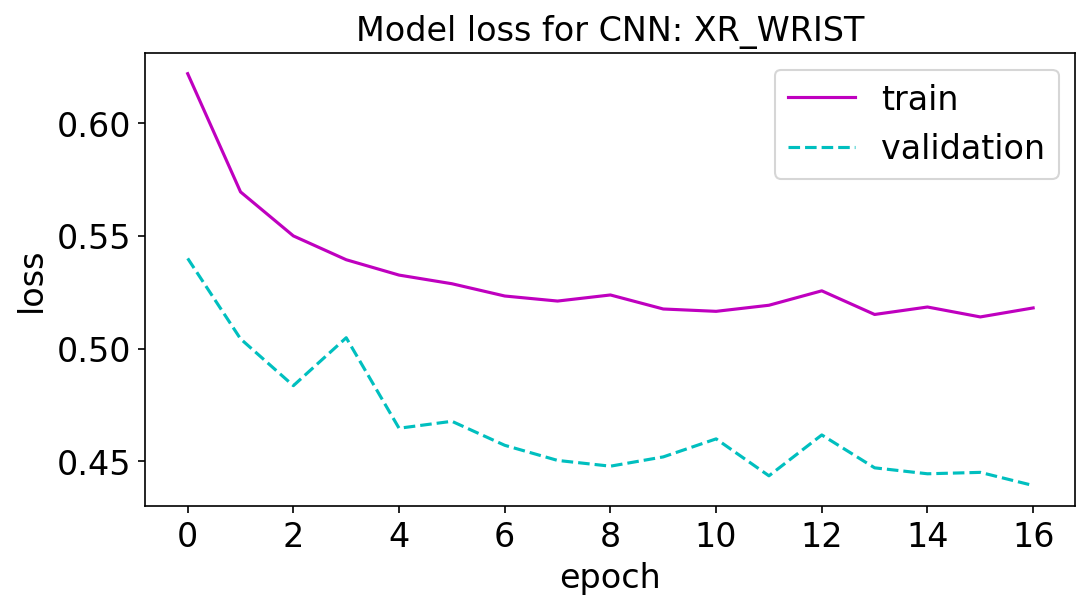

<Figure size 432x288 with 0 Axes>

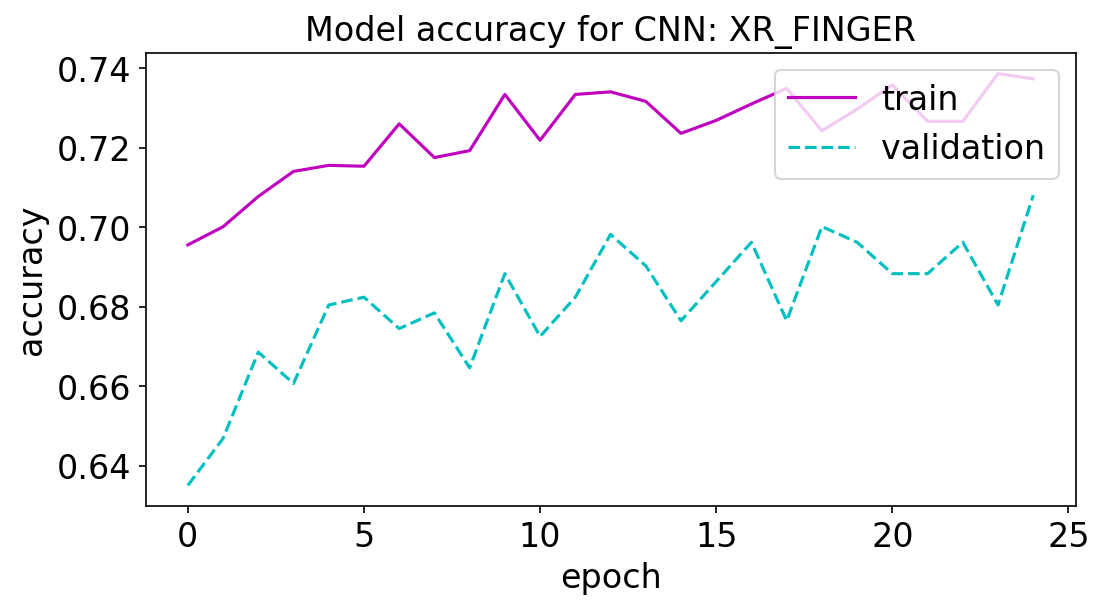

<Figure size 432x288 with 0 Axes>

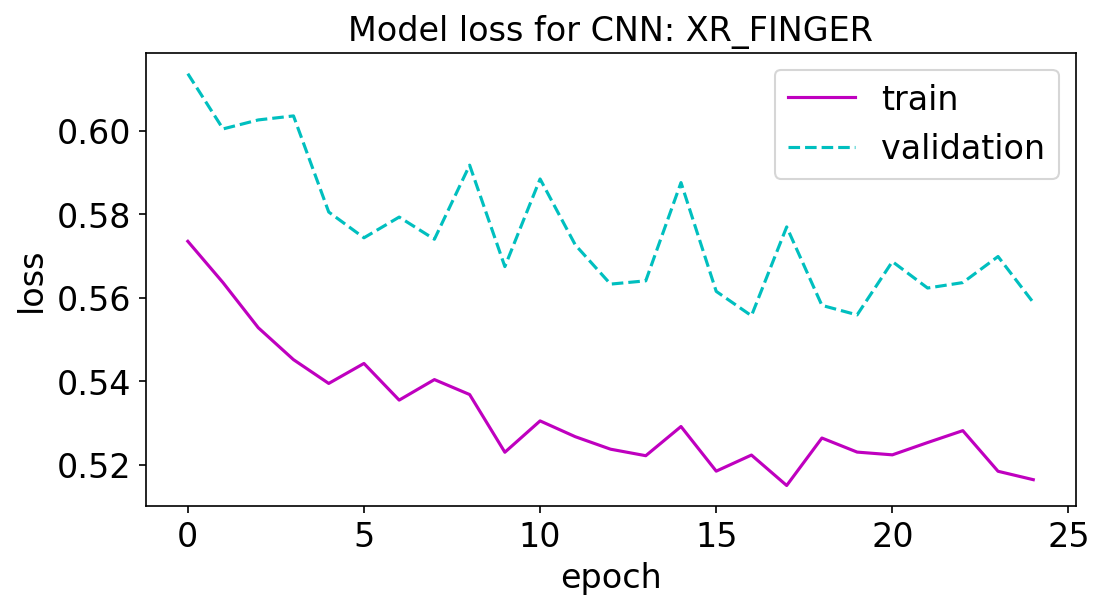

<Figure size 432x288 with 0 Axes>

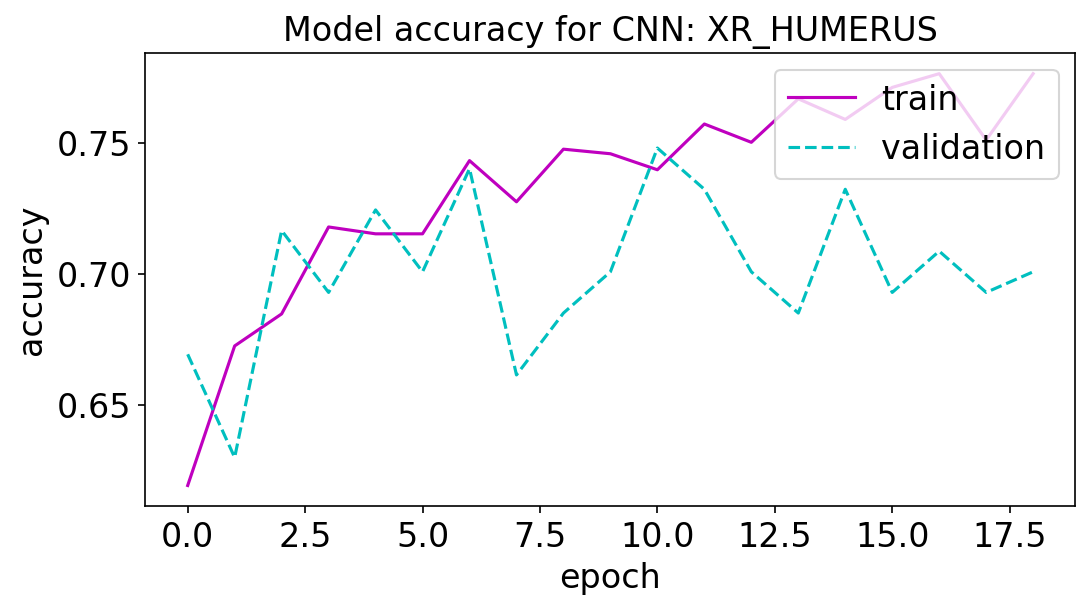

<Figure size 432x288 with 0 Axes>

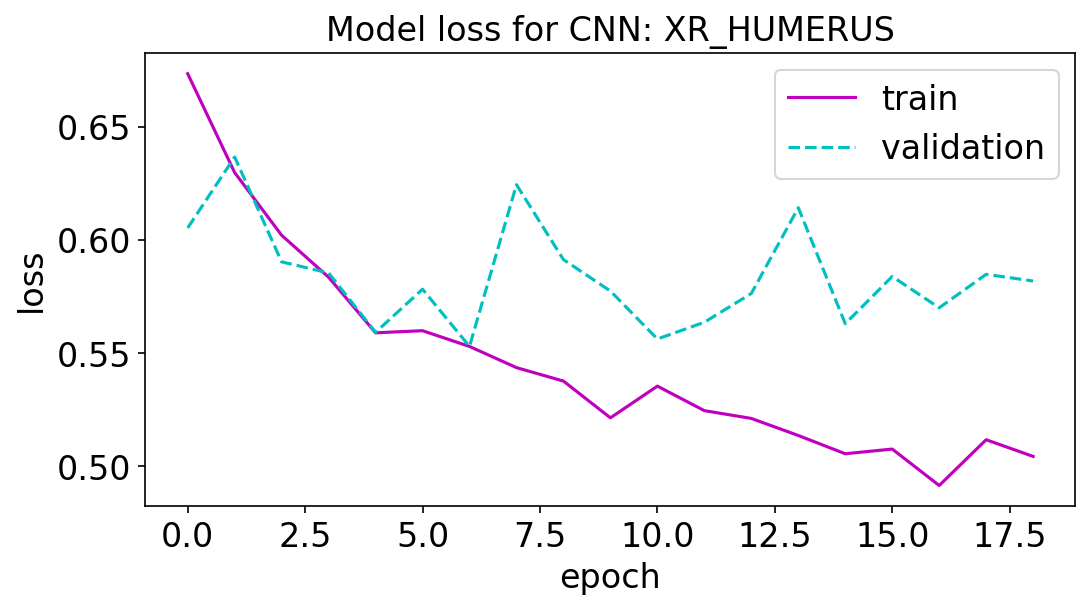

<Figure size 432x288 with 0 Axes>

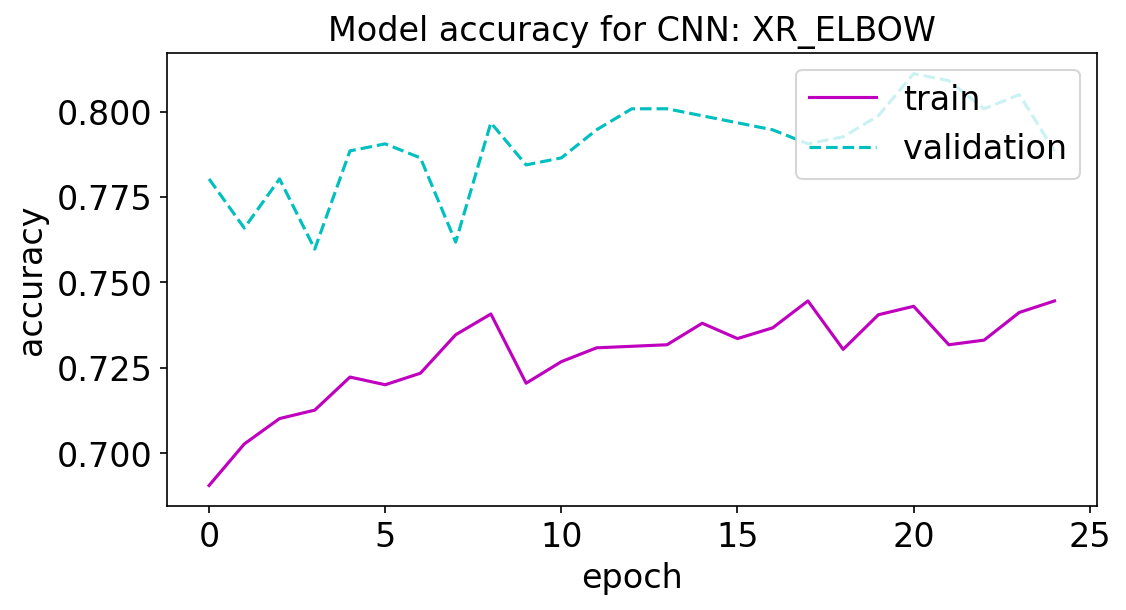

<Figure size 432x288 with 0 Axes>

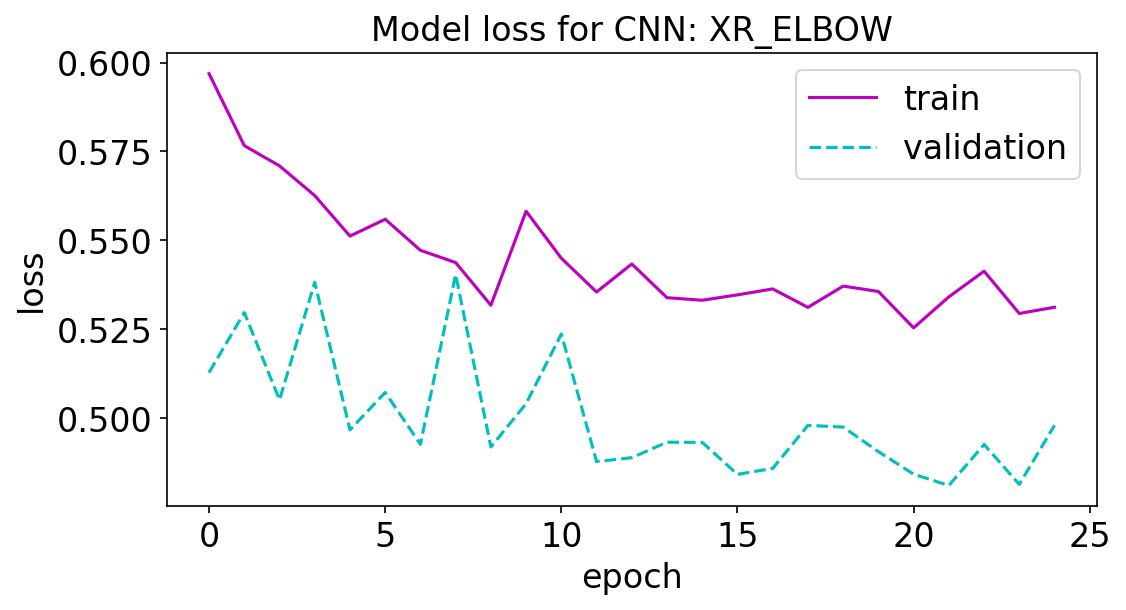

<Figure size 432x288 with 0 Axes>

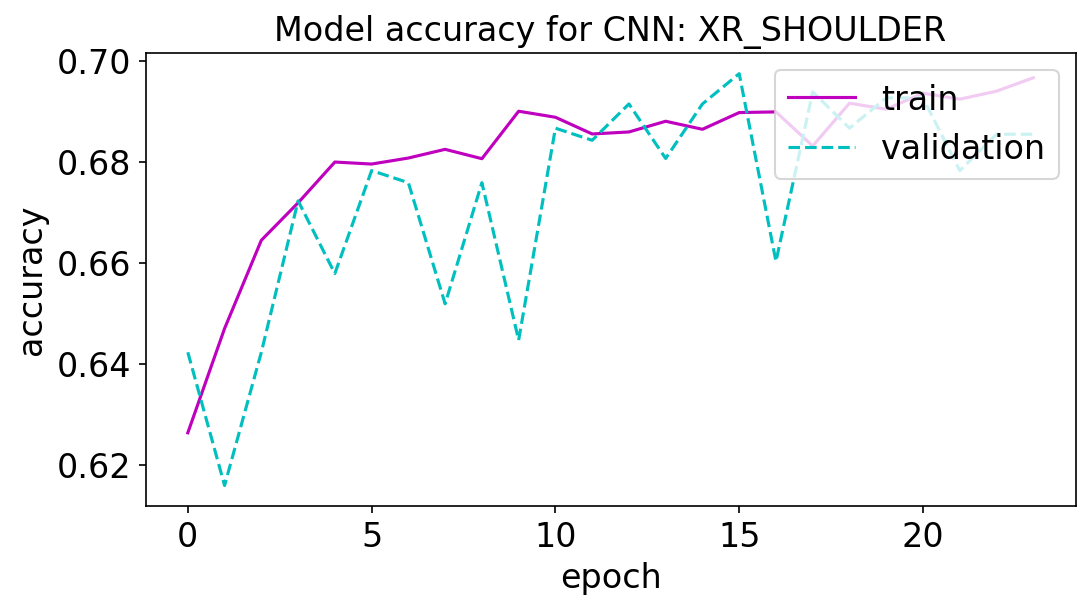

<Figure size 432x288 with 0 Axes>

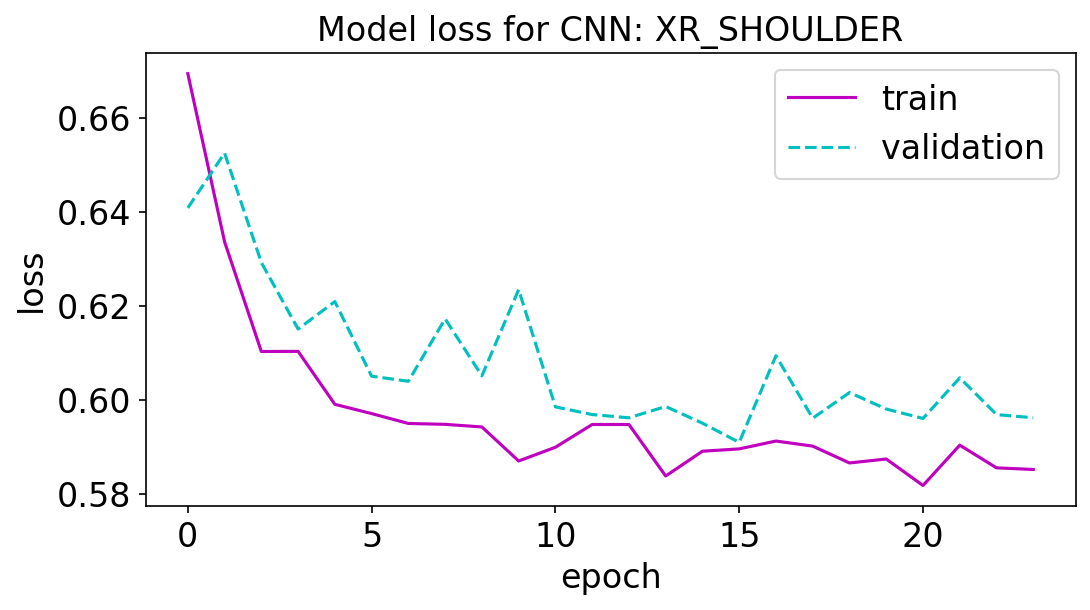

<Figure size 432x288 with 0 Axes>

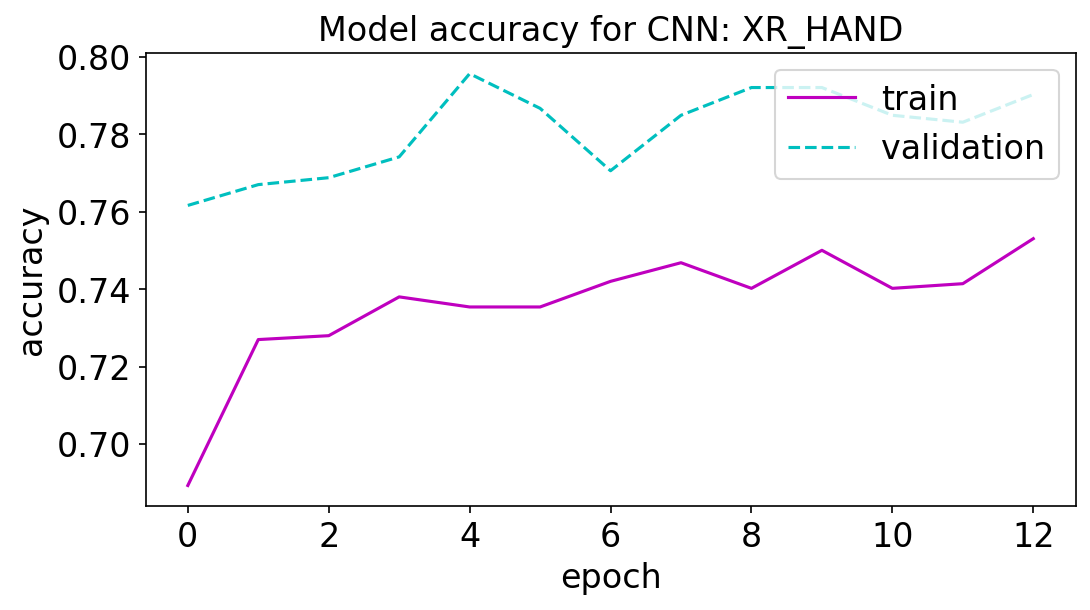

<Figure size 432x288 with 0 Axes>

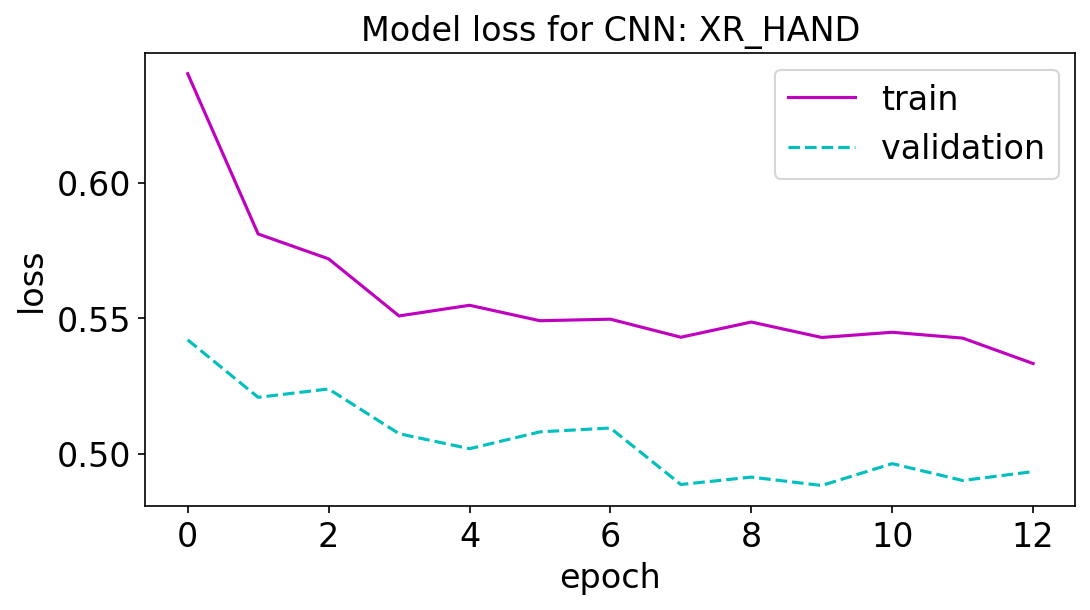

<Figure size 432x288 with 0 Axes>

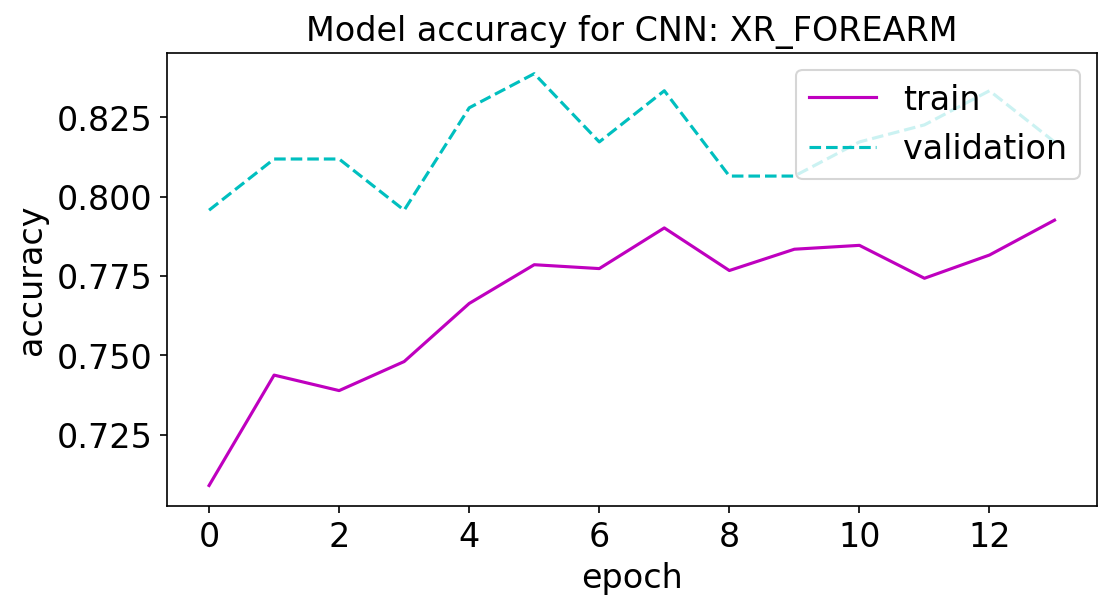

<Figure size 432x288 with 0 Axes>

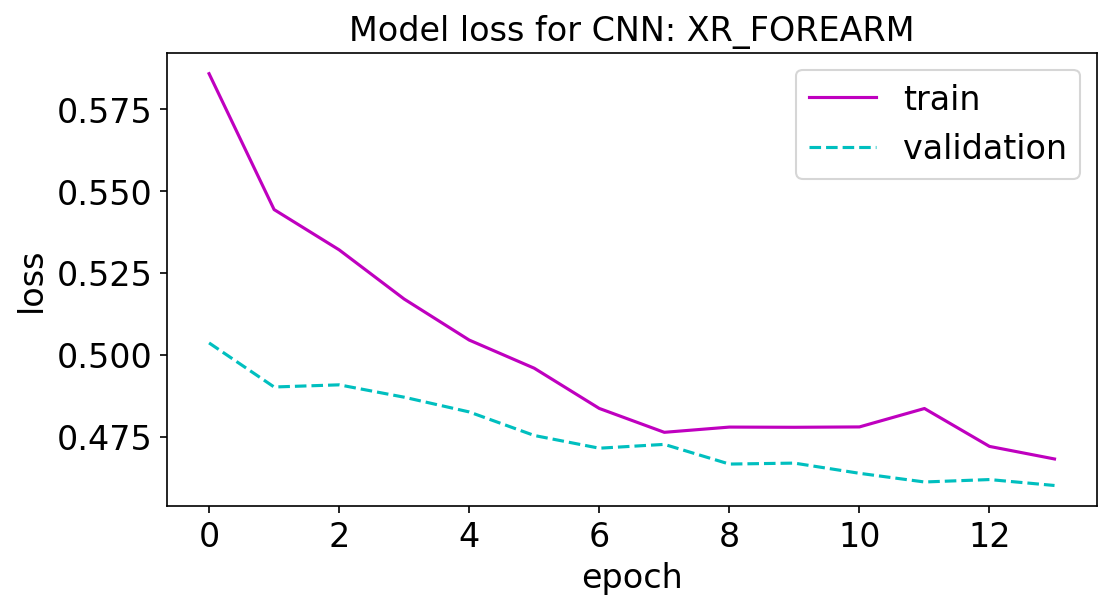

<Figure size 432x288 with 0 Axes>

In [41]:
# this is wrong data_augmentation='noaugment', 
# correct above data_augmentation='light_augment'
for bodypart in bodyparts:
    plot_learning_curves.plot_history(densenet_model_top_histories[bodypart], 
                                     bodypart,
                                     'densenet',
                                     25,
                                     data_augmentation='light_augment')

## ResNet152

### Build

In [6]:
# add model on top
def build_model_on_resnet():
  # DenseNet model
  resnet_model = tf.keras.applications.resnet.ResNet152(weights='imagenet',
                                                        input_shape = (320,320,3),
                                                        include_top = False)
  resnet_model.trainable = False
  # add new model on top
  inputs = tf.keras.Input(shape=(320,320,3))
  x = resnet_model(inputs, 
                    training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs, outputs)
  model.summary()

  # train the top layer
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss = 'binary_crossentropy',
                metrics = ['binary_accuracy'])
  return model

In [43]:
resnet_model_top = build_model_on_resnet()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
resnet152 (Functional)       (None, 10, 10, 2048)      58370944  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 58,372,993
Trainable params: 2,049
Non-trainable params: 58,370,944
_________________________________________________________________


### Train

In [8]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=8,
                                             verbose=1)

    
def train_model(model, bodypart):
    validation_steps = math.ceil(valid_generators[bodypart].n/ valid_generators[bodypart].batch_size)
    print("Using validation_steps = %d" % validation_steps)
    steps_per_epoch = math.ceil(train_generators[bodypart].n / (train_generators[bodypart].batch_size))
    print("Using steps_per_epoch = %d" % steps_per_epoch)
    history = model.fit(train_generators[bodypart],
                        validation_data = valid_generators[bodypart],
                        validation_steps = validation_steps,
                        steps_per_epoch = steps_per_epoch,
                        epochs=20,
                        verbose=1,
                        callbacks=[callbacks]
    )
    return history

In [45]:
resnet_model_top_histories = {}
for bodypart in set(train.bodypart):
    print('-----------')
    print(bodypart)
    model = build_model_on_resnet()
    resnet_model_top_histories[bodypart] = train_model(model, 
                              bodypart)
    print('\nSave training history\n')
    with open("data/history/resnet_20epochs_light_augment_"+bodypart+".json", "w") as file:
        json.dump(resnet_model_top_histories[bodypart].history, file)
        print('\nSave model\n')
    print('\nSave model\n')
    model.save("data/models/resnet_20epochs_light_augment_"+bodypart)
    model.save("data/models/resnet_20epochs_light_augment_"+bodypart+".h5")
    print('\nEvaluate model\n')
    eval_func(test[test['bodypart'] == bodypart]['class'], 
                    model.predict(test_generators[bodypart]))
    print('evaluate_test_generators')
    model.evaluate(test_generators[bodypart], verbose=1)
    print('evaluate_train_generators')
    model.evaluate(train_generators[bodypart], verbose=1)
    print('evaluate_valid_generators')
    model.evaluate(valid_generators[bodypart], verbose=1)
    print("Delete model")
    clean_up(model)

-----------
XR_WRIST
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
resnet152 (Functional)       (None, 10, 10, 2048)      58370944  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 58,372,993
Trainable params: 2,049
Non-trainable params: 58,370,944
_________________________________________________________________
Epoch 1/20
52/52 [==============================] - 180s 3s/step - loss: 0.7679 - binary

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



52/52 [==============================] - 176s 3s/step - loss: 0.6580 - binary_accuracy: 0.6482 - val_loss: 0.6468 - val_binary_accuracy: 0.6505
Epoch 11/20
52/52 [==============================] - 164s 3s/step - loss: 0.6685 - binary_accuracy: 0.6230 - val_loss: 0.6460 - val_binary_accuracy: 0.6505
Epoch 12/20
52/52 [==============================] - 172s 3s/step - loss: 0.6724 - binary_accuracy: 0.6136 - val_loss: 0.6438 - val_binary_accuracy: 0.6505
Epoch 13/20
52/52 [==============================] - 170s 3s/step - loss: 0.6419 - binary_accuracy: 0.6650 - val_loss: 0.6550 - val_binary_accuracy: 0.6505
Epoch 14/20
52/52 [==============================] - 161s 3s/step - loss: 0.6573 - binary_accuracy: 0.6398 - val_loss: 0.6589 - val_binary_accuracy: 0.6505
Epoch 15/20
52/52 [==============================] - 153s 3s/step - loss: 0.6655 - binary_accuracy: 0.6187 - val_loss: 0.6655 - val_binary_accuracy: 0.6505
Epoch 16/20
52/52 [==============================] - 154s 3s/step - loss: 0.

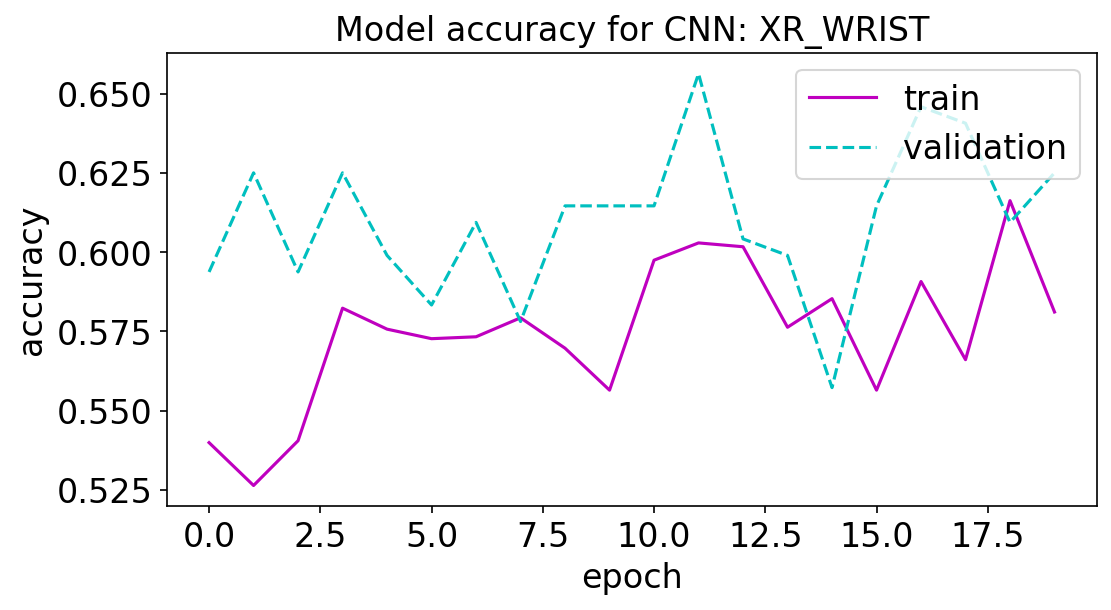

<Figure size 432x288 with 0 Axes>

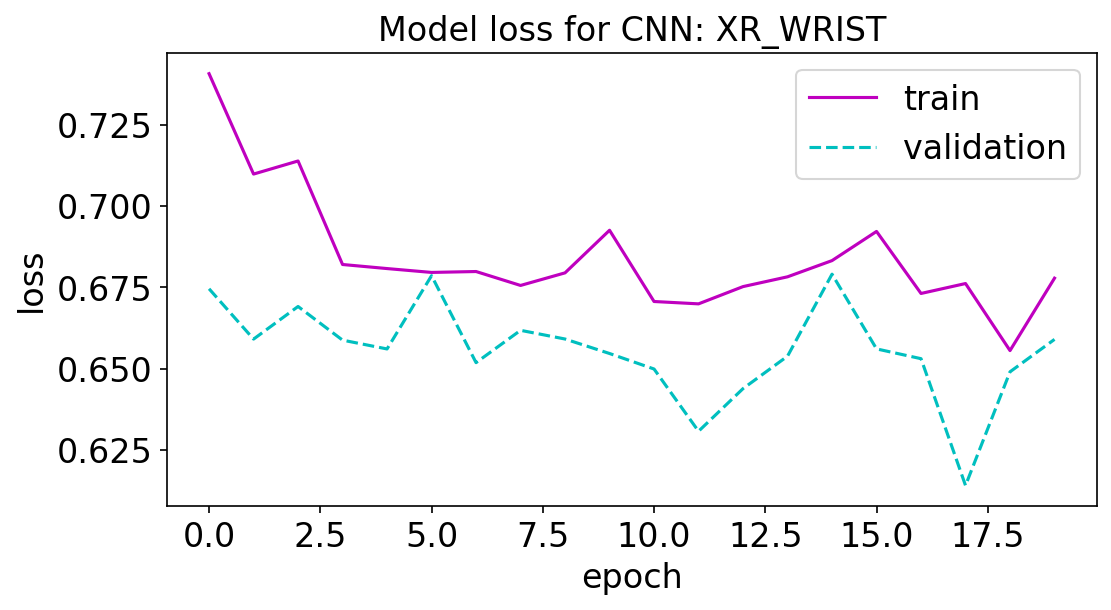

<Figure size 432x288 with 0 Axes>

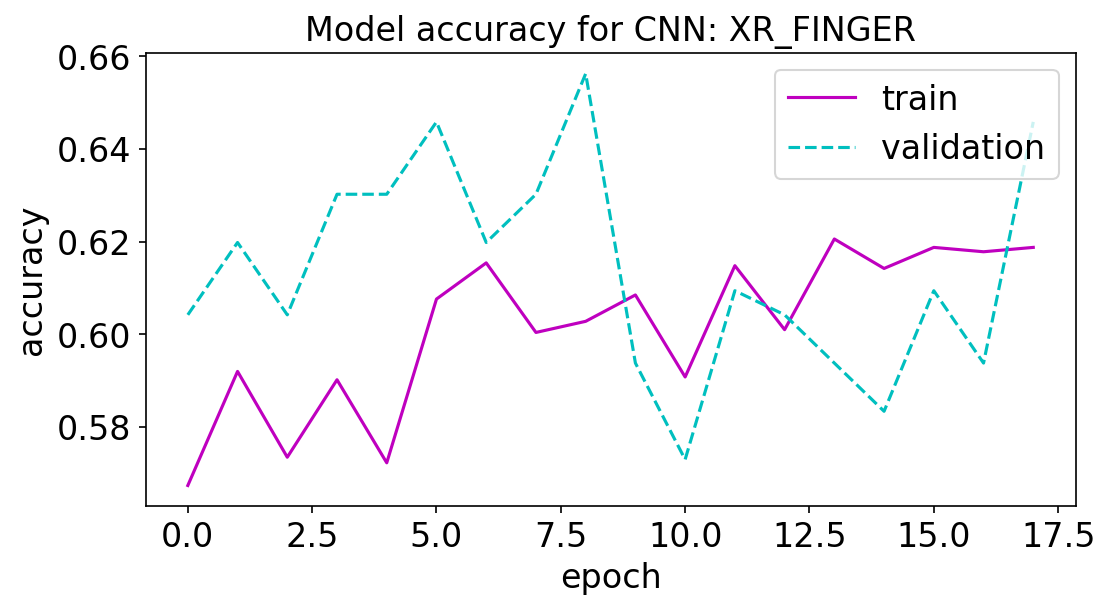

<Figure size 432x288 with 0 Axes>

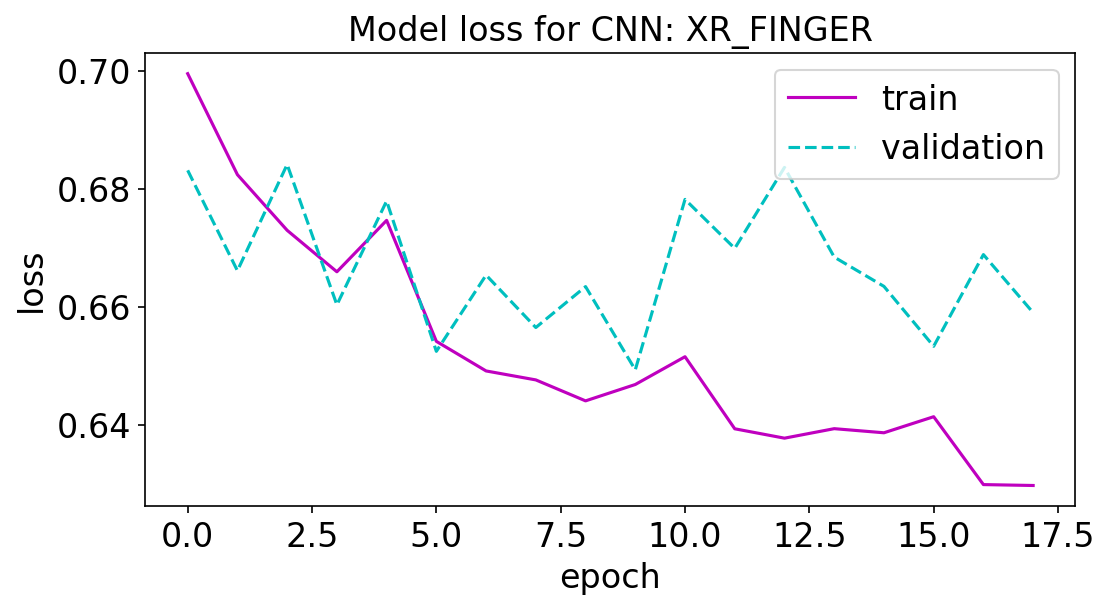

<Figure size 432x288 with 0 Axes>

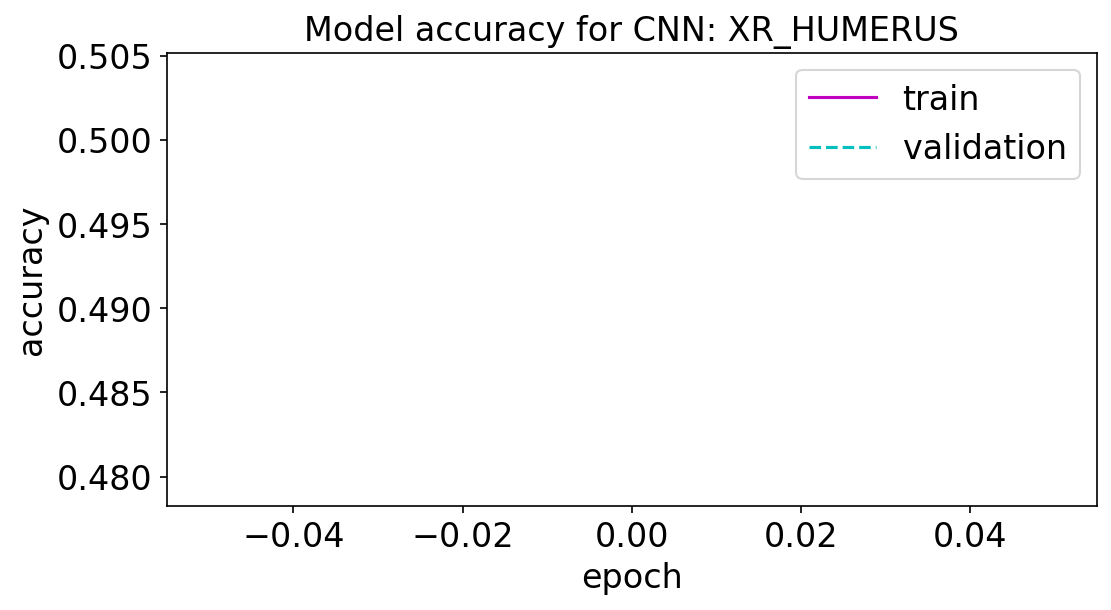

<Figure size 432x288 with 0 Axes>

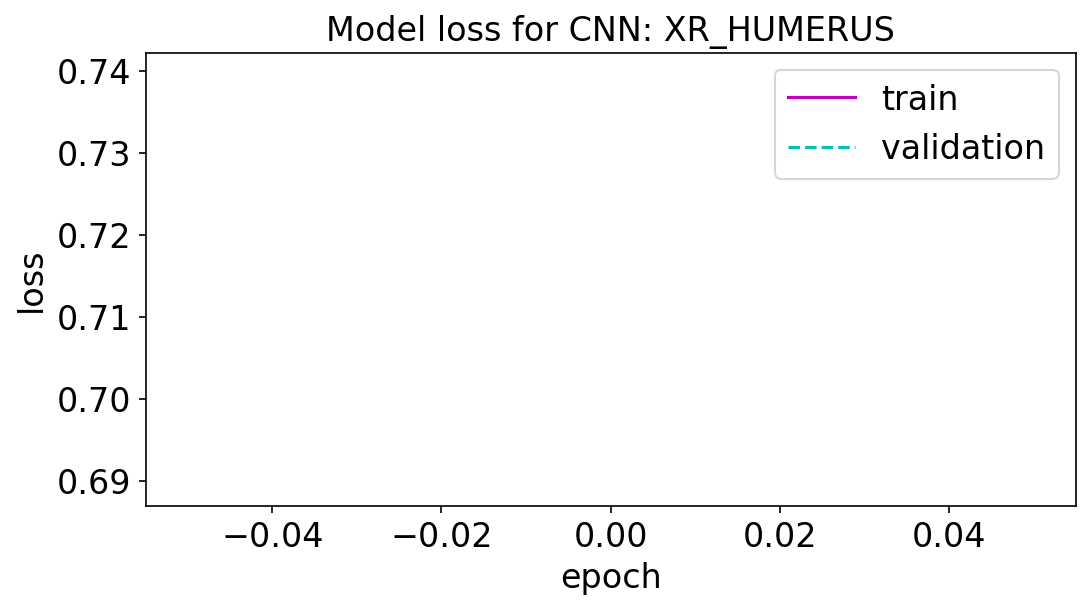

<Figure size 432x288 with 0 Axes>

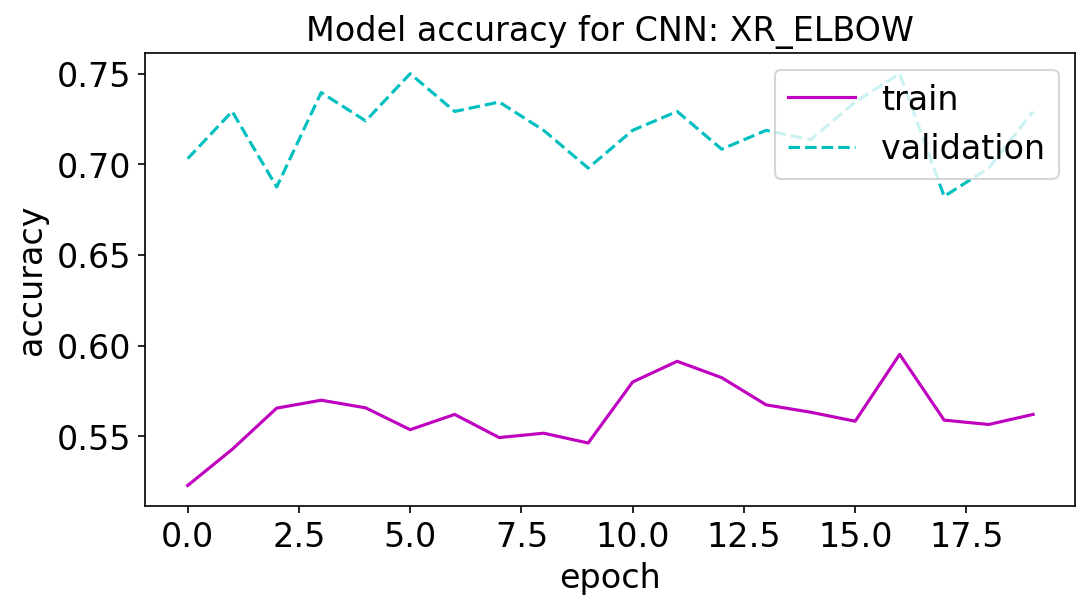

<Figure size 432x288 with 0 Axes>

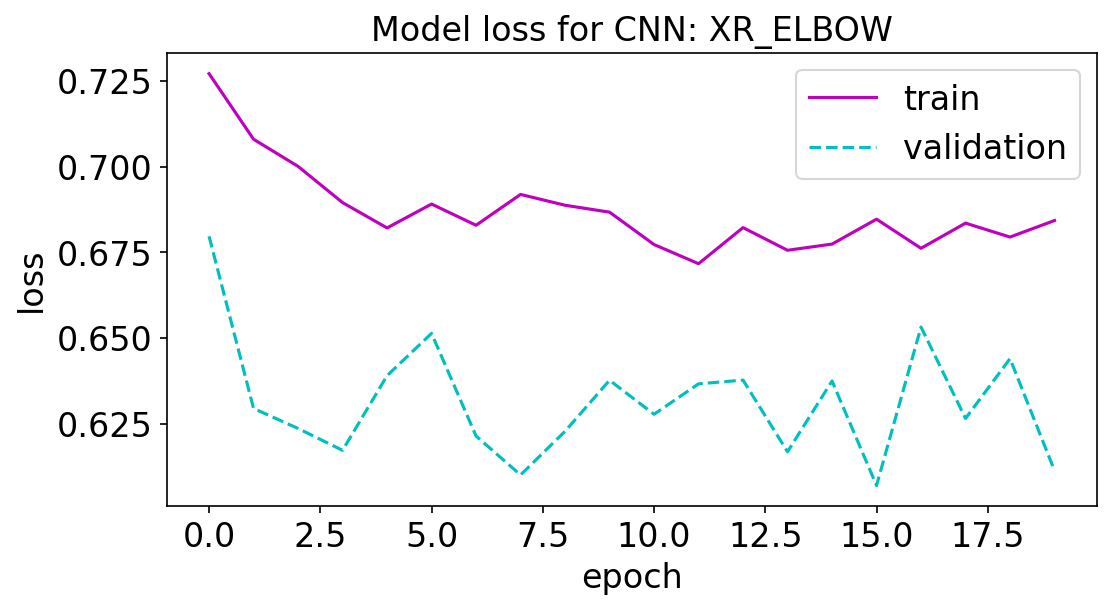

<Figure size 432x288 with 0 Axes>

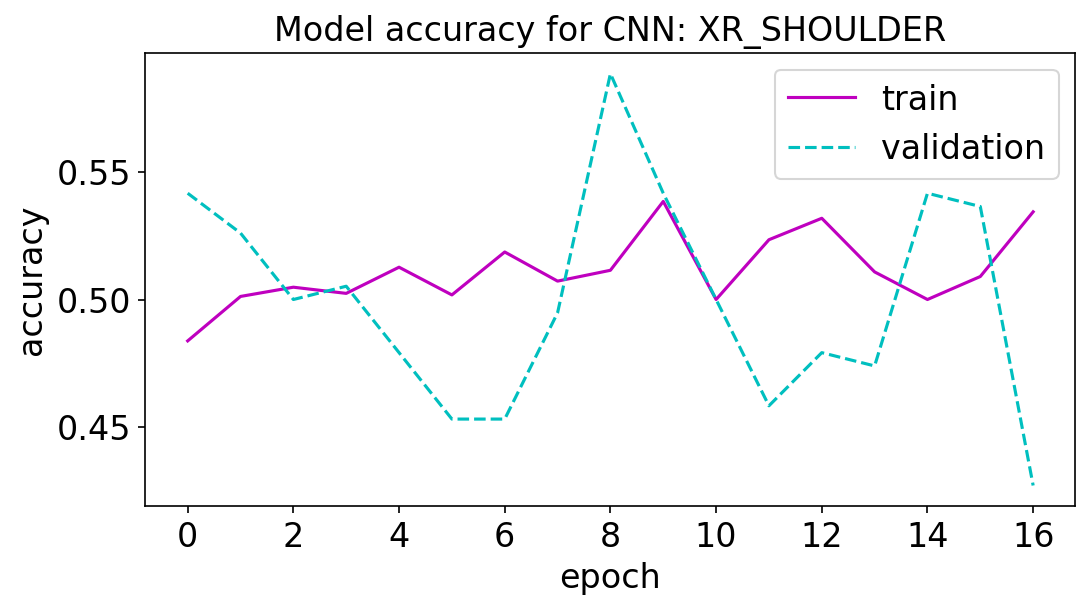

<Figure size 432x288 with 0 Axes>

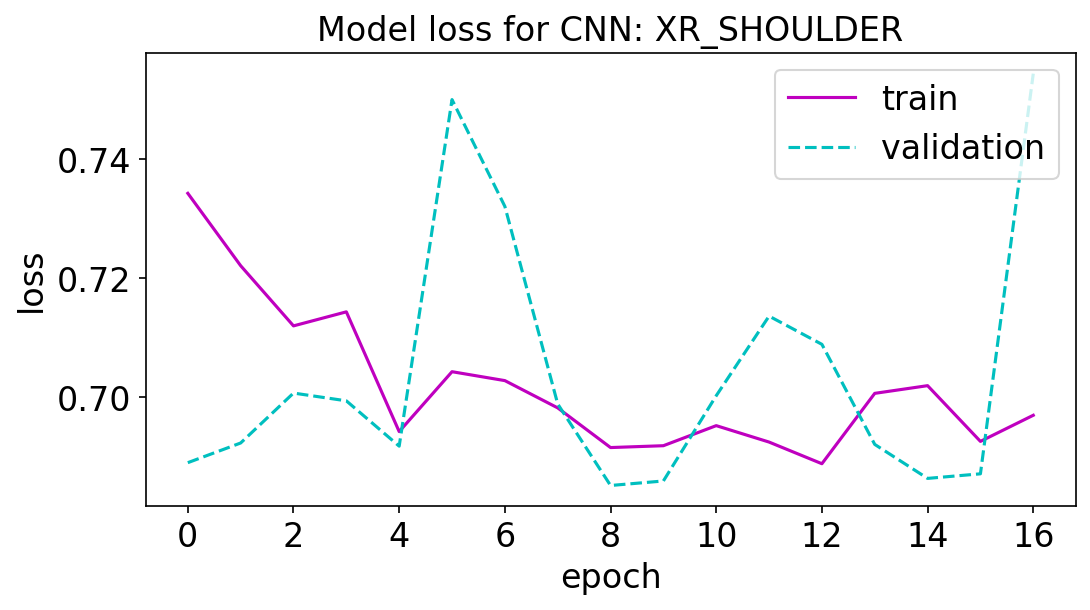

<Figure size 432x288 with 0 Axes>

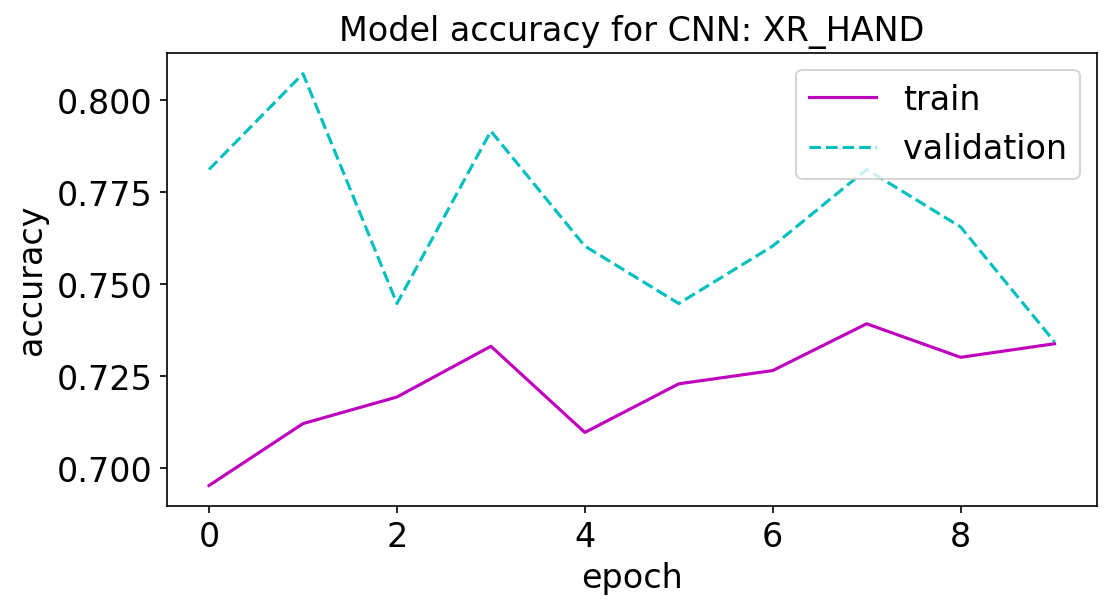

<Figure size 432x288 with 0 Axes>

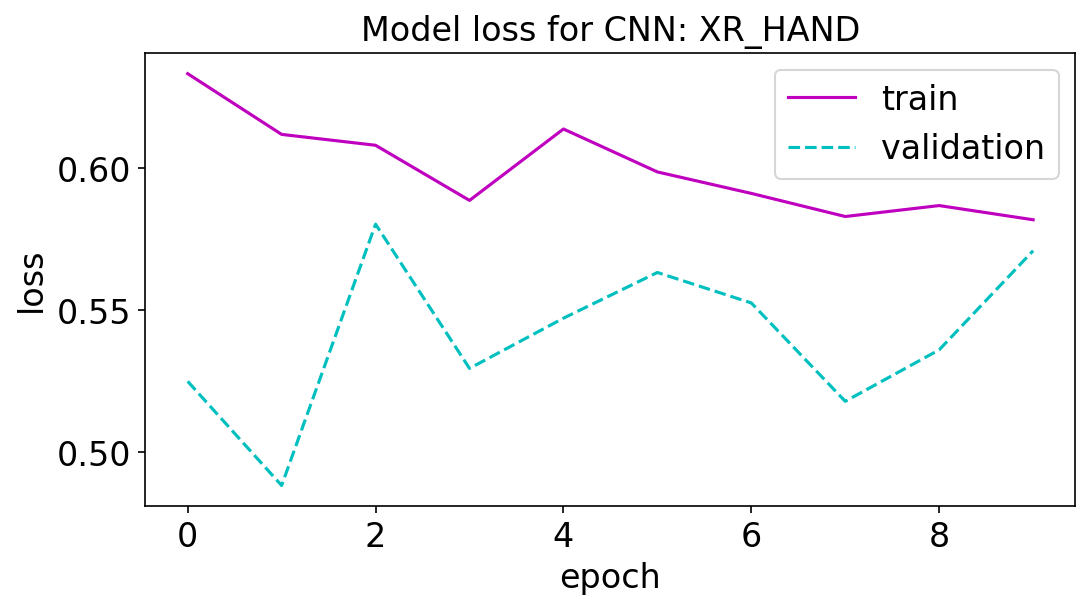

<Figure size 432x288 with 0 Axes>

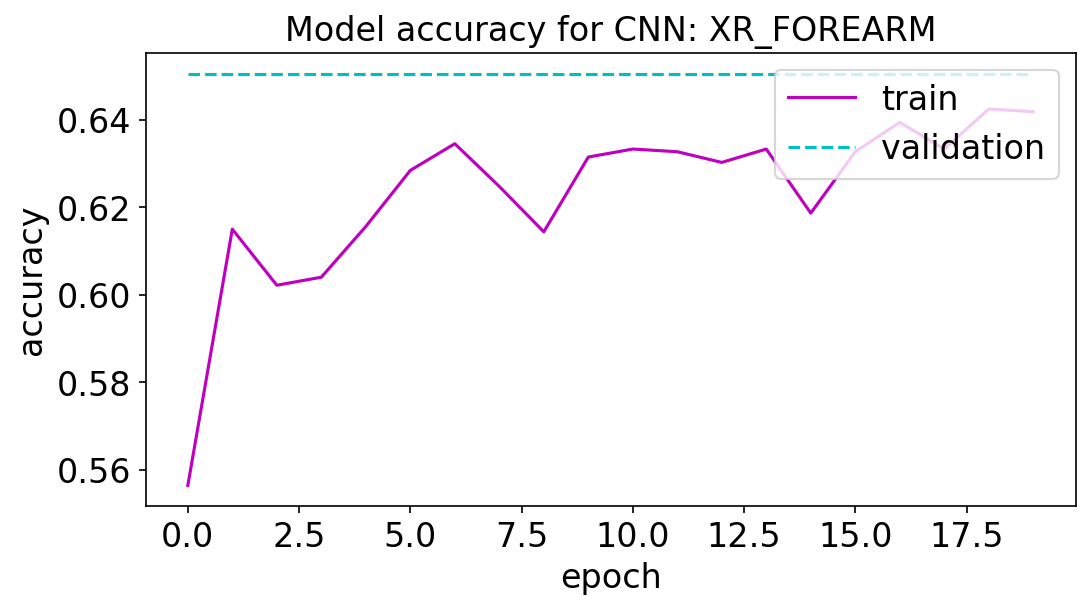

<Figure size 432x288 with 0 Axes>

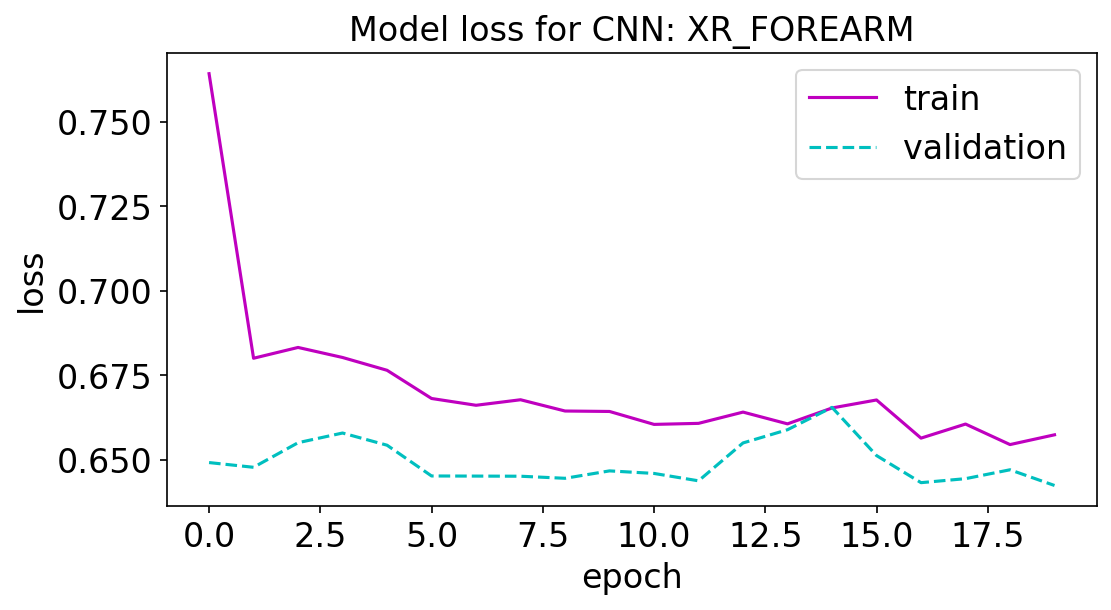

<Figure size 432x288 with 0 Axes>

In [46]:
for bodypart in bodyparts:
    plot_learning_curves.plot_history(resnet_model_top_histories[bodypart], 
                                     bodypart,
                                     'resnet_',
                                     20,
                                     data_augmentation='light_augment')

## Additional runs

In [9]:
bodyparts

{'XR_ELBOW',
 'XR_FINGER',
 'XR_FOREARM',
 'XR_HAND',
 'XR_HUMERUS',
 'XR_SHOULDER',
 'XR_WRIST'}

In [10]:
bodyparts_left = ['XR_FOREARM',
                  'XR_HAND']

In [15]:
resnet_model_top_histories_left = {}
for bodypart in bodyparts_left:
    print('-----------')
    print(bodypart)
    model = build_model_on_resnet()
    resnet_model_top_histories_left[bodypart] = train_model(model, 
                              bodypart)
    print('\nSave training history\n')
    with open("data/history/resnet_20epochs_light_augment_"+bodypart+".json", "w") as file:
        json.dump(resnet_model_top_histories_left[bodypart].history, file)
        print('\nSave model\n')
    print('\nSave model\n')
    model.save("data/models/resnet_20epochs_light_augment_"+bodypart)
    model.save("data/models/resnet_20epochs_light_augment_"+bodypart+".h5")
    print('\nEvaluate model\n')
    eval_func(test[test['bodypart'] == bodypart]['class'], 
                    model.predict(test_generators[bodypart]))
    print('evaluate_test_generators')
    model.evaluate(test_generators[bodypart], verbose=1)
    print('evaluate_train_generators')
    model.evaluate(train_generators[bodypart], verbose=1)
    print('evaluate_valid_generators')
    model.evaluate(valid_generators[bodypart], verbose=1)
    print("Delete model")
    clean_up(model)

-----------
XR_FOREARM
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
resnet152 (Functional)       (None, 10, 10, 2048)      58370944  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 58,372,993
Trainable params: 2,049
Non-trainable params: 58,370,944
_________________________________________________________________
Using validation_steps = 6
Using steps_per_epoch = 52
Epoch 1/20
52/52 [==============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 100s 7s/step - loss: 0.6786 - binary_accuracy: 0.5891
evaluate_train_generators
156/156 [==============================] - 1080s 7s/step - loss: 0.6353 - binary_accuracy: 0.7348
evaluate_valid_generators
18/18 [==============================] - 110s 6s/step - loss: 0.6510 - binary_accuracy: 0.7096
Delete model


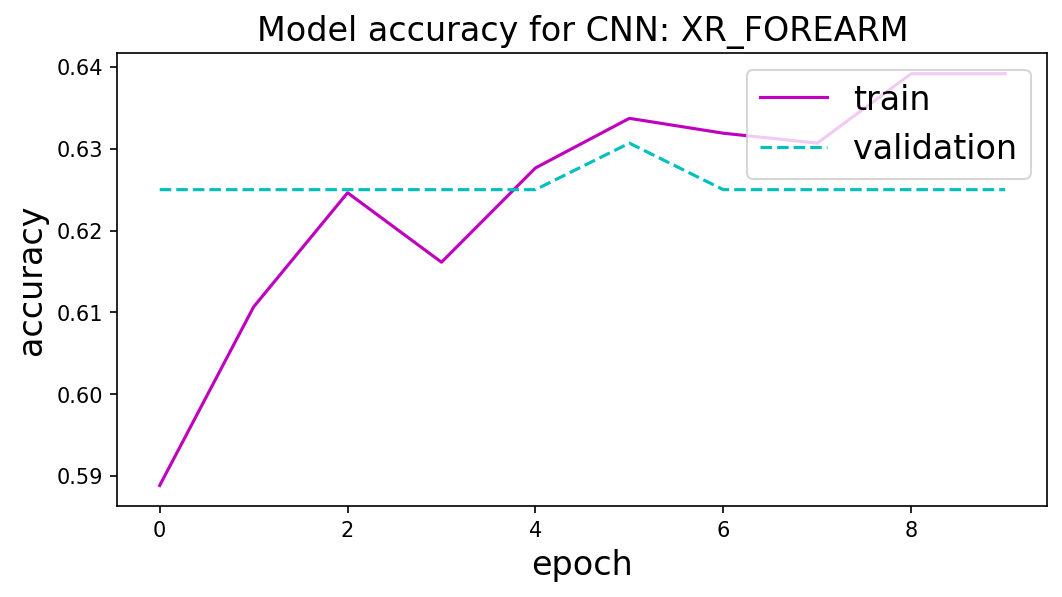

<Figure size 432x288 with 0 Axes>

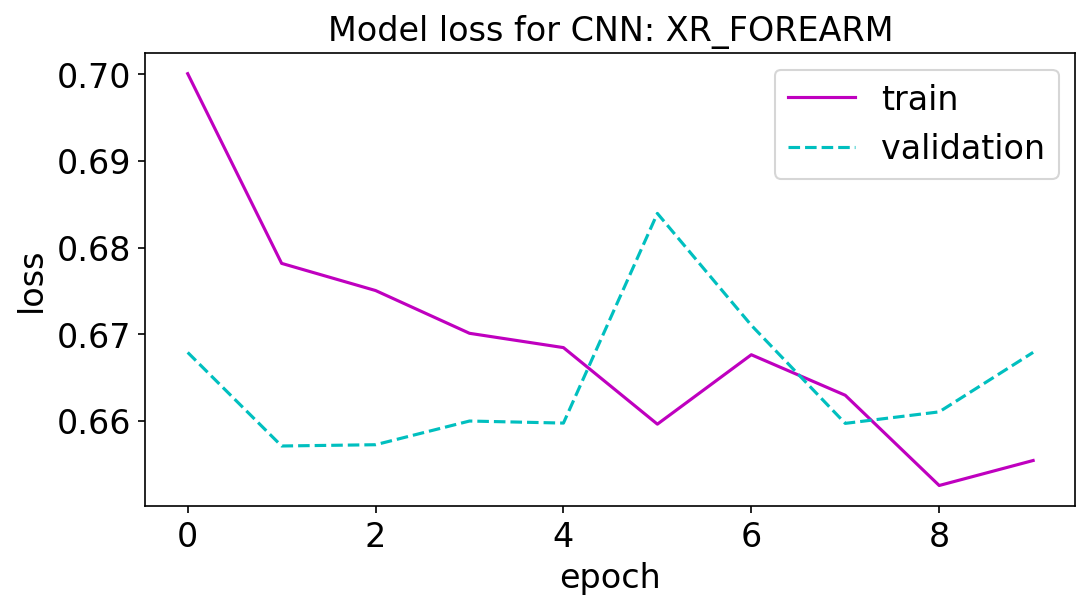

<Figure size 432x288 with 0 Axes>

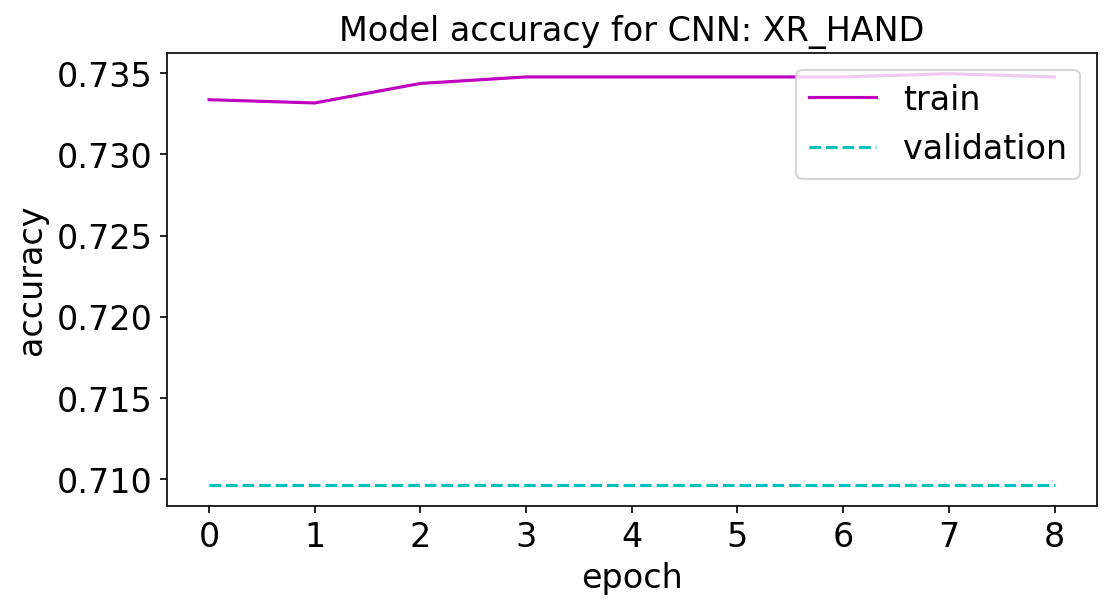

<Figure size 432x288 with 0 Axes>

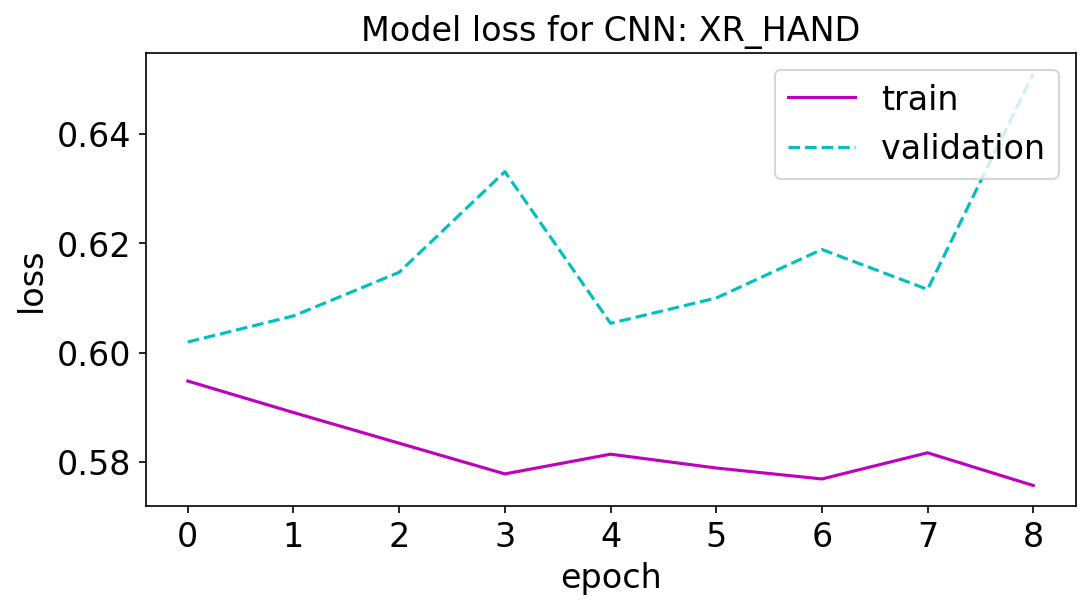

<Figure size 432x288 with 0 Axes>

In [16]:
for bodypart in bodyparts_left:
    plot_learning_curves.plot_history(resnet_model_top_histories_left[bodypart], 
                                     bodypart,
                                     'resnet_',
                                     20,
                                     data_augmentation='light_augment')